In [1]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [2]:
def new_get_nSPEI(eff_pr, months = range(1,13), calibration_period = slice("1980", "2010")):
    '''
    Summary:
    -----------
    Computes a the monthly SPEI value. 
    
    Parameters:
    -----------
    eff_pr: xarray DataArray object 
            - Effective Precipitation / Water Balance, defined via Precipitation - Potential Evapotranspiration
            - must be a DataArray with a time dimension labelled as a DateTime object
         
    months: range object
            - describing the months of the year for which the SPEI value should be calculated
             
    calibration_period: slice object
            - describing the calibration timeperiod, needs to be within the dataset
         
    Returns:
    ----------
    spei: xarray DataArray oject
            - The SPEI values              
    '''

    ## NB CURRENTLY NOTHING IN PLACE TO HANDLE DRY PERIODS IN THE TIME SERIES - USE WITH CAUTION!
    
    # create empty list to hold results
    spei_monthly = []
    # fit each calendar month in turn
    for m in months:    
        # select current calendar month
        epr_m = eff_pr.sel(time = eff_pr.time.dt.month == m)     
        # estimate parameters over calibration period (PWM seems to give more robust fit, so using xclim fit method - also applies over whole spatial array)
        epr_cal = epr_m.sel(time = calibration_period).copy()    
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])    
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(glo.cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        spei_monthly.append(spei_finite) 

    # concatenate monthly fitted values, reorder & relabel
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei")  
    # clean out existing attributes and replace with new variable description
    for k in list(spei.attrs.keys()): del spei.attrs[k]
    spei = spei.assign_attrs(notes = "Calibrated against "+str(calibration_period.start)+"-"+str(calibration_period.stop))
    spei = spei.where(~np.isnan(eff_pr)).dropna("time", "all")
    
    # Replace exactly zero values with linear interpolation as these are fit-failures
    zero_mask = (spei == 0)
    spei_zero_filled = spei.where(~zero_mask)  # keep non-zero values as they are
    spei_interpolated = spei_zero_filled.interpolate_na(dim="time", method="linear")
    
    # Combine the interpolated values back into the original array, but only for positions where spei was zero
    spei = xr.where(zero_mask, spei_interpolated, spei)

    return spei

def mse_2(num_parameters, predictions, targets):
    '''
    Summary:
    -----------
    Computes the Mean Square Error (MSE). 
    
    Parameters:
    -----------
    num_parameters: float
            - number of parameters used in representing the fitted distribution
            
    predictions: Array object 
            - Contains the predicted values
         
    targets: Array object
            - Containts the observational, target values
         
    Returns:
    ----------
    mse: float
            - Value representing the Mean Square Error              
    '''
    n = len(predictions)
    mse = ((predictions - targets) ** 2).sum()/(n - num_parameters)
    return mse

def aic(num_parameters,loglikelihood_discret):
    '''
    Summary:
    -----------
    Computes the Akaike Information Criterion (AIC). 
    
    Parameters:
    -----------
    loglikelihood_discret: scipy obejct
            - containt the .logpdf object of the respecitve distribtution which is evaluated
            
    predictions: Array object 
            - Contains the predicted values, namely the CDF of the fitted parameters
         
    Returns:
    ----------
    aic: float
            - Value representing the Akaike Information Criterion              
    '''
    
    loglikelihood_discret_sum = loglikelihood_discret.sum()
    aic = 2 * num_parameters - 2 * loglikelihood_discret_sum
    return aic

def cdf_estimator_test(fitted_copula,num_repeat):
    '''
    Summary:
    -----------
    Computes the Capéraá-Fougéres-Genest (CFG) estimator. 
    
    Parameters:
    -----------
    fitted_copula: sklarpy Object
            - sklarpy object which represents the fitted copula 
            
    num_repeat: Float
            - Contains the number of repetitions used to calculate the average
         
    Returns:
    ----------
    lambda_arr_mean: float
            - Value representing the Capéraá-Fougéres-Genest (CFG) estimator              
    '''
    #create array with length of repetition
    lambda_arr = np.zeros(num_repeat)
    
    #for-loop with the number of repetitions
    for t in np.arange(0,num_repeat,1):
        #define how many samples should be created
        n=1000

        #create sample of copula
        sample=fitted_copula.copula_rvs(n)

        #get the sum value
        sum_temp=0
        
        for i in np.arange(0,n,1):
            max_value = max(sample[i][0],sample[i][1])
            sum_temp += np.log(np.sqrt(np.log(1/sample[i][0])*np.log(1/sample[i][1]))/np.log(1/(max_value**2)))

        #rest of formula
        lambda_U_cfg = 2 - 2*np.exp(1/n*sum_temp)
        
        #Update array
        lambda_arr[t]=lambda_U_cfg

    #get mean on array
    lambda_arr_mean = lambda_arr.mean()
    return lambda_arr_mean

def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

## Load in the Data

In [6]:
#This line should point to the directory of the mswep/mswx data
dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/mswep_mswx/'
model_name = 'mswep_mswx'

### mswep

In [4]:
mswep_pr = xr.open_mfdataset("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/mswep_mswx/mswep_pr/precip*").precipitation.sel(time=slice("1950","2023"))
mswep_tmax = xr.open_mfdataset("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/mswep_mswx/mswx_tmax/tmax*").air_temperature.sel(time=slice("1950","2023"))
mswep_tmin = xr.open_mfdataset("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/mswep_mswx/mswx_tmin/tmin*").air_temperature.sel(time=slice("1950","2023"))

### Calc potential evapotranspiration

In [5]:
#Note: Use of Unit conversion: 1 kg m-2 s-1 = 86400 mm day-1
pet_HG85 = xc_i.potential_evapotranspiration(tasmin=mswep_tmin,tasmax=mswep_tmax,method='HG85')*86400
pet_HG85.attrs['units'] = 'mm/day'

eff_precip_HG85 = mswep_pr-pet_HG85
eff_precip_HG85.attrs['units'] = 'mm/day'

#only take the land area into account
land = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(eff_precip_HG85.lon, eff_precip_HG85.lat)
eff_precip_land = eff_precip_HG85.where(land==0)

eff_precip_land_M = eff_precip_land.resample(time="MS").mean(dim="time")

### Save evaluation files

In [4]:
#Only put loaded_eff_eval to False to load the calibration time period in a seperate directory to perform the evaluation
loaded_eff_eval = False
if loaded_eff_eval == True:
    eval_eff_precip_land_m = eff_precip_land_m.sel(time=slice("1980","2010"))
    eval_eff_precip_land_m.load()
    eval_eff_precip_land_m.to_netcdf("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/mswep_mswx/eff_precip/eval_eff_precip_land_m.nc") 
    
    eval_eff_precip_land = eff_precip_land.sel(time=slice("1980","2010"))
    eval_eff_precip_land_mdoy = eval_eff_precip_land.where(rm_SA).groupby("time.dayofyear").mean(dim="time")
    eval_eff_precip_land_mdoy_CUT_mLL_arr = np.zeros((8,366))
    for s in np.arange(9,16):
        eval_eff_precip_land_mdoy_CUT = eval_eff_precip_land_mdoy.sel(region=s)
        weights = np.cos(np.deg2rad(eval_eff_precip_land_mdoy_CUT.lat))
        weights.name = "weights"
        eval_eff_precip_land_mdoy_CUT_w = eval_eff_precip_land_mdoy_CUT.weighted(weights)
        eval_eff_precip_land_mdoy_CUT_w_mLL = eval_eff_precip_land_mdoy_CUT_w.mean(("lon", "lat"))
        eval_eff_precip_land_mdoy_CUT_mLL_arr[s-8] = eval_eff_precip_land_mdoy_CUT_w_mLL.to_numpy()
        eval_eff_precip_land_mdoy_CUT_mLL_arr[0] = eval_eff_precip_land_mdoy_CUT_w_mLL.dayofyear.to_numpy()
    np.savetxt("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/mswep_mswx/eff_precip/eval_eff_precip_land_mdoy_CUT_wmLL_arr.csv",eval_eff_precip_land_mdoy_CUT_mLL_arr,delimiter=";")

### Define Aggregation Time

In [ ]:
#Calculate the different aggregation times
eff_precip_land_M6 = eff_precip_land_M.rolling(time=6).mean()
eff_precip_land_M12 = eff_precip_land_M.rolling(time=12).mean()

#define which effective precipitation value shoud be used
eff_precip = eff_precip_land_M
#Change to 1, 6 or 12 according to which eff_precip is used
spei_M_str = str(1)

### Load Regions

In [ ]:
#This line should refer to the directory of the IPCC AR6 region shapefiles
sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]

fn_load_lat_lon = dir_data + 'eff_precip/eval_eff_precip_land_m.nc'
load_lat_lon = xr.open_dataset(fn_load_lat_lon)
load_lat_lon = load_lat_lon.__xarray_dataarray_variable__

rm_SA = regionmask.mask_3D_geopandas(sf_SA, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, load_lat_lon.lon, load_lat_lon.lat).squeeze(drop = True)

### Calc SPEI

In [ ]:
#Change to False if the calculation is not already performed once to store the data in the specified directory
loaded = True

In [ ]:
#make sure that the directory "nSPEI_HG85_cal1980_2010" exists
if loaded == False:
    eff_precip_m_9 = eff_precip.where(rm_9)
    weights_9 = np.cos(np.deg2rad(eff_precip_m_9.lat))
    weights_9.name = "weights"
    eff_precip_m_9_weighted = eff_precip_m_9.weighted(weights_9)
    eff_precip_m_9_mm = eff_precip_m_9_weighted.mean(("lon", "lat"))
    eff_precip_m_9_mm.load()
    spei_M1_9 = new_get_nSPEI(eff_precip_m_9_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_9 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_9.nc"
    spei_M1_9.to_netcdf(fn_spei_M1_9)
    eff_precip_m_10 = eff_precip.where(rm_10)
    weights_10 = np.cos(np.deg2rad(eff_precip_m_10.lat))
    weights_10.name = "weights"
    eff_precip_m_10_weighted = eff_precip_m_10.weighted(weights_10)
    eff_precip_m_10_mm = eff_precip_m_10_weighted.mean(("lon", "lat"))
    eff_precip_m_10_mm.load()
    spei_M1_10 = new_get_nSPEI(eff_precip_m_10_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_10 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_10.nc"
    spei_M1_10.to_netcdf(fn_spei_M1_10)
    eff_precip_m_11 = eff_precip.where(rm_11)
    weights_11 = np.cos(np.deg2rad(eff_precip_m_11.lat))
    weights_11.name = "weights"
    eff_precip_m_11_weighted = eff_precip_m_11.weighted(weights_11)
    eff_precip_m_11_mm = eff_precip_m_11_weighted.mean(("lon", "lat"))
    eff_precip_m_11_mm.load()
    spei_M1_11 = new_get_nSPEI(eff_precip_m_11_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_11 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_11.nc"
    spei_M1_11.to_netcdf(fn_spei_M1_11)
    eff_precip_m_12 = eff_precip.where(rm_12)
    weights_12 = np.cos(np.deg2rad(eff_precip_m_12.lat))
    weights_12.name = "weights"
    eff_precip_m_12_weighted = eff_precip_m_12.weighted(weights_12)
    eff_precip_m_12_mm = eff_precip_m_12_weighted.mean(("lon", "lat"))
    eff_precip_m_12_mm.load()
    spei_M1_12 = new_get_nSPEI(eff_precip_m_12_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_12 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_12.nc"
    spei_M1_12.to_netcdf(fn_spei_M1_12)   
    eff_precip_m_13 = eff_precip.where(rm_13)
    weights_13 = np.cos(np.deg2rad(eff_precip_m_13.lat))
    weights_13.name = "weights"
    eff_precip_m_13_weighted = eff_precip_m_13.weighted(weights_13)
    eff_precip_m_13_mm = eff_precip_m_13_weighted.mean(("lon", "lat"))
    eff_precip_m_13_mm.load()
    spei_M1_13 = new_get_nSPEI(eff_precip_m_13_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_13 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_13.nc"
    spei_M1_13.to_netcdf(fn_spei_M1_13)
    eff_precip_m_14 = eff_precip.where(rm_14)
    weights_14 = np.cos(np.deg2rad(eff_precip_m_14.lat))
    weights_14.name = "weights"
    eff_precip_m_14_weighted = eff_precip_m_14.weighted(weights_14)
    eff_precip_m_14_mm = eff_precip_m_14_weighted.mean(("lon", "lat"))
    eff_precip_m_14_mm.load()
    spei_M1_14 = new_get_nSPEI(eff_precip_m_14_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_14 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_14.nc"
    spei_M1_14.to_netcdf(fn_spei_M1_14)
    eff_precip_m_15 = eff_precip.where(rm_15)
    weights_15 = np.cos(np.deg2rad(eff_precip_m_15.lat))
    weights_15.name = "weights"
    eff_precip_m_15_weighted = eff_precip_m_15.weighted(weights_15)
    eff_precip_m_15_mm = eff_precip_m_15_weighted.mean(("lon", "lat"))
    eff_precip_m_15_mm.load()
    spei_M1_15 = new_get_nSPEI(eff_precip_m_15_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_15 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_15.nc"
    spei_M1_15.to_netcdf(fn_spei_M1_15)

In [ ]:
#make sure that the directory "nSPEI_HG85_cal1980_2010" exists
if loaded == False:
    eff_precip_m_9 = eff_precip.where(rm_9)
    weights_9 = np.cos(np.deg2rad(eff_precip_m_9.lat))
    weights_9.name = "weights"
    eff_precip_m_9_weighted = eff_precip_m_9.weighted(weights_9)
    eff_precip_m_9_mm = eff_precip_m_9_weighted.mean(("lon", "lat"))
    eff_precip_m_9_mm.load()
    spei_M1_9 = new_get_nSPEI(eff_precip_m_9_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_9 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_9.nc"
    spei_M1_9.to_netcdf(fn_spei_M1_9)
    eff_precip_m_10 = eff_precip.where(rm_10)
    weights_10 = np.cos(np.deg2rad(eff_precip_m_10.lat))
    weights_10.name = "weights"
    eff_precip_m_10_weighted = eff_precip_m_10.weighted(weights_10)
    eff_precip_m_10_mm = eff_precip_m_10_weighted.mean(("lon", "lat"))
    eff_precip_m_10_mm.load()
    spei_M1_10 = new_get_nSPEI(eff_precip_m_10_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_10 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_10.nc"
    spei_M1_10.to_netcdf(fn_spei_M1_10)
    eff_precip_m_11 = eff_precip.where(rm_11)
    weights_11 = np.cos(np.deg2rad(eff_precip_m_11.lat))
    weights_11.name = "weights"
    eff_precip_m_11_weighted = eff_precip_m_11.weighted(weights_11)
    eff_precip_m_11_mm = eff_precip_m_11_weighted.mean(("lon", "lat"))
    eff_precip_m_11_mm.load()
    spei_M1_11 = new_get_nSPEI(eff_precip_m_11_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_11 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_11.nc"
    spei_M1_11.to_netcdf(fn_spei_M1_11)
    eff_precip_m_12 = eff_precip.where(rm_12)
    weights_12 = np.cos(np.deg2rad(eff_precip_m_12.lat))
    weights_12.name = "weights"
    eff_precip_m_12_weighted = eff_precip_m_12.weighted(weights_12)
    eff_precip_m_12_mm = eff_precip_m_12_weighted.mean(("lon", "lat"))
    eff_precip_m_12_mm.load()
    spei_M1_12 = new_get_nSPEI(eff_precip_m_12_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_12 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_12.nc"
    spei_M1_12.to_netcdf(fn_spei_M1_12)   
    eff_precip_m_13 = eff_precip.where(rm_13)
    weights_13 = np.cos(np.deg2rad(eff_precip_m_13.lat))
    weights_13.name = "weights"
    eff_precip_m_13_weighted = eff_precip_m_13.weighted(weights_13)
    eff_precip_m_13_mm = eff_precip_m_13_weighted.mean(("lon", "lat"))
    eff_precip_m_13_mm.load()
    spei_M1_13 = new_get_nSPEI(eff_precip_m_13_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_13 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_13.nc"
    spei_M1_13.to_netcdf(fn_spei_M1_13)
    eff_precip_m_14 = eff_precip.where(rm_14)
    weights_14 = np.cos(np.deg2rad(eff_precip_m_14.lat))
    weights_14.name = "weights"
    eff_precip_m_14_weighted = eff_precip_m_14.weighted(weights_14)
    eff_precip_m_14_mm = eff_precip_m_14_weighted.mean(("lon", "lat"))
    eff_precip_m_14_mm.load()
    spei_M1_14 = new_get_nSPEI(eff_precip_m_14_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_14 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_14.nc"
    spei_M1_14.to_netcdf(fn_spei_M1_14)
    eff_precip_m_15 = eff_precip.where(rm_15)
    weights_15 = np.cos(np.deg2rad(eff_precip_m_15.lat))
    weights_15.name = "weights"
    eff_precip_m_15_weighted = eff_precip_m_15.weighted(weights_15)
    eff_precip_m_15_mm = eff_precip_m_15_weighted.mean(("lon", "lat"))
    eff_precip_m_15_mm.load()
    spei_M1_15 = new_get_nSPEI(eff_precip_m_15_mm, calibration_period = slice("1980", "2010"))
    fn_spei_M1_15 = dir_data + "nSPEI_HG85_cal1980_2010/spei_M" + spei_M_str + "_15.nc"
    spei_M1_15.to_netcdf(fn_spei_M1_15)

### Calculating the results

The following code calculates the Goodness-of-Fit Tools for the marginal distribtion fitting to make an informed decision on which distribution performes best for the duration and severity data of the respective region. It also visualises some of the results.

### Region 9

number of pairs 57
PearsonR Duration and Severity: PearsonRResult(statistic=0.9757497270447764, pvalue=5.654564420079391e-38)
Duration Fit:


/rds/general/user/nmerz/home/.conda/envs/thesis/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2509: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  303.020249     0.005742   0.008109     0.216158
1        Gamma  299.332237     0.013345   0.097912     0.159619
2      LogNorm  283.574317     0.008017   0.302626     0.125719
3      Weibull  303.572710     0.009235   0.054669     0.174523

-----> best fit according to AIC_normal: LogNorm
Severity Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  340.820576     0.008622   0.020648     0.196893
1        Gamma  340.490960     0.009148   0.114804     0.155297
2      LogNorm  314.170382     0.002654   0.600206     0.098703
3      Weibull  342.820552     0.008779   0.020504     0.197044

-----> best fit according to AIC_normal: LogNorm


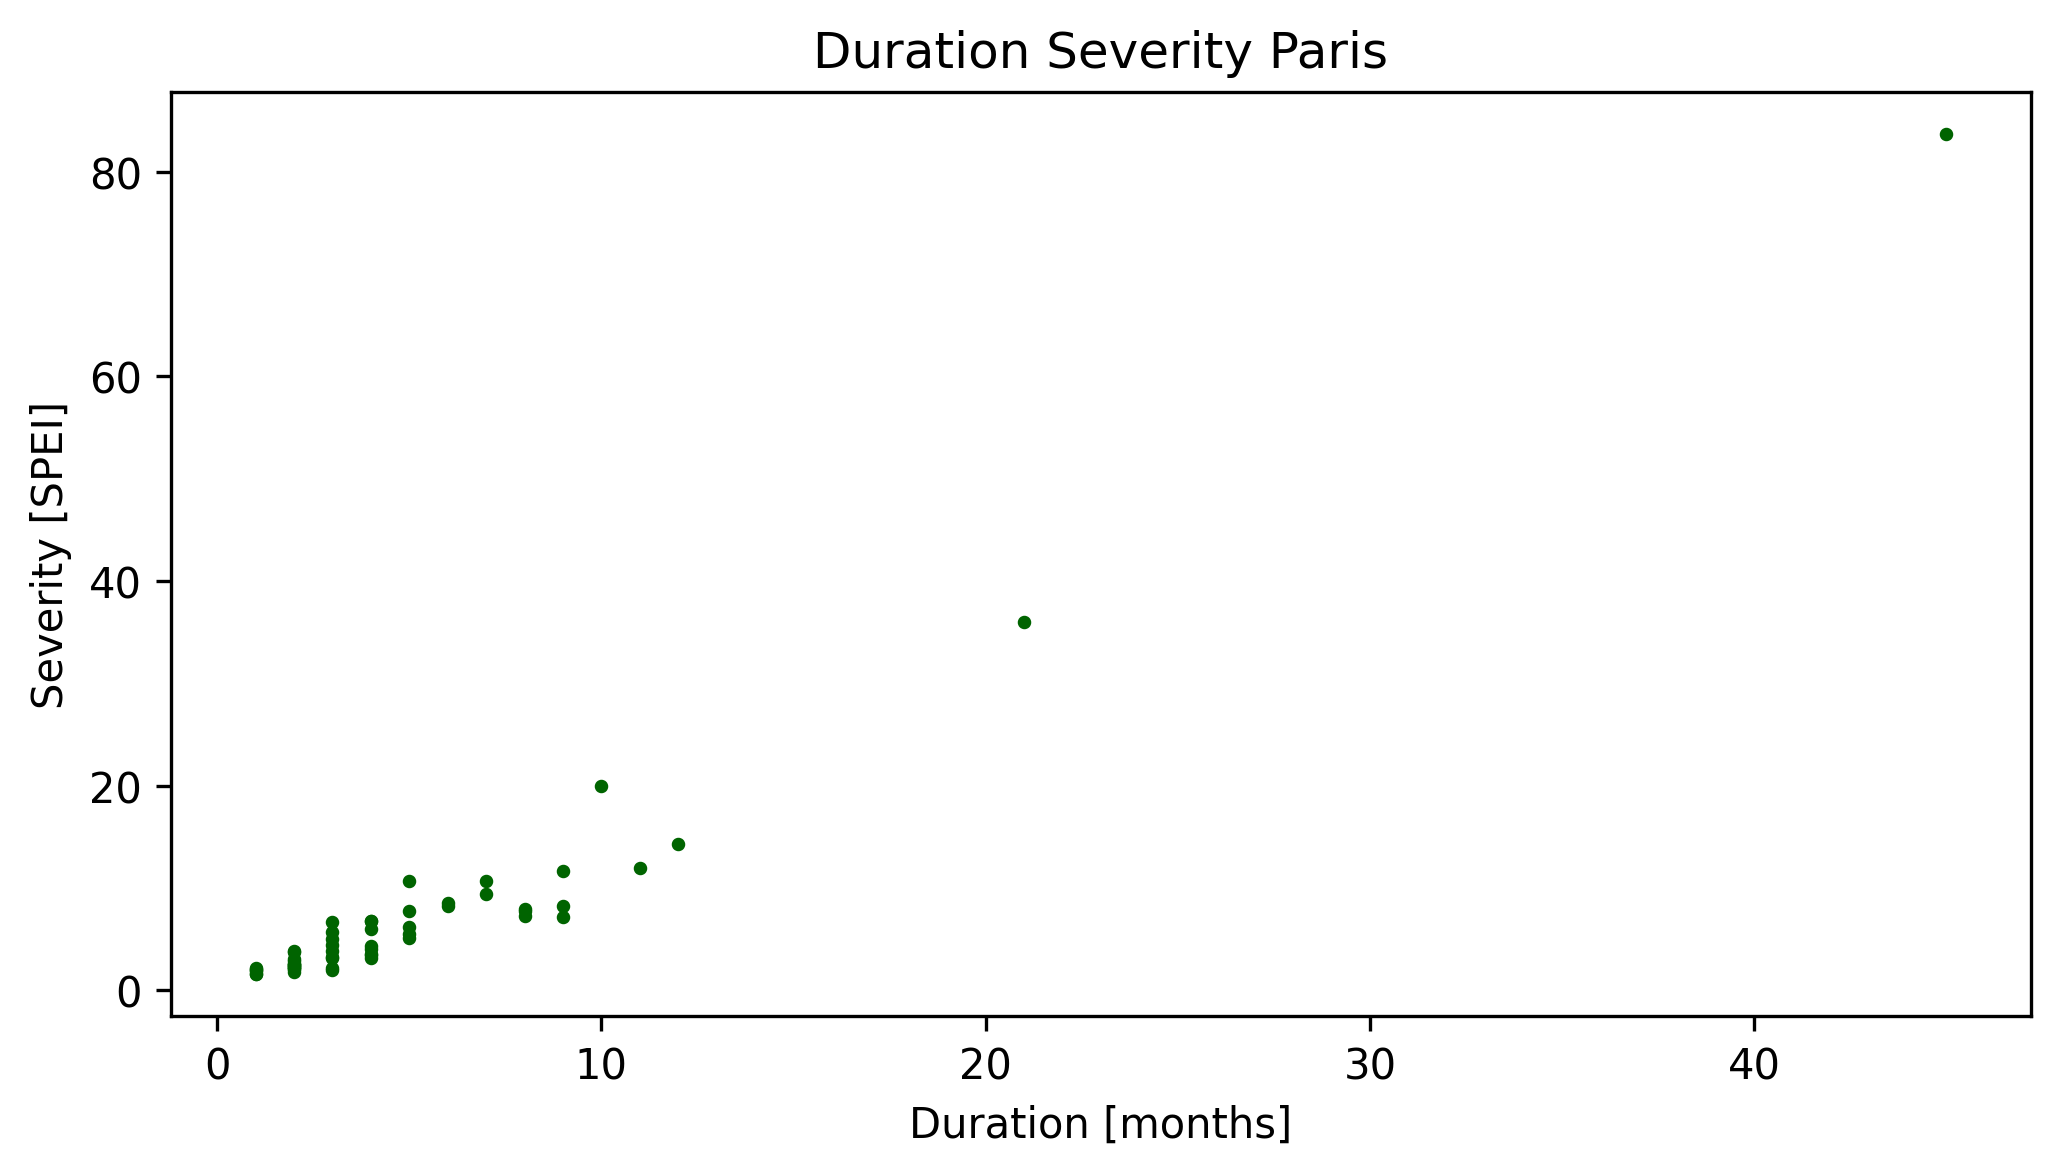

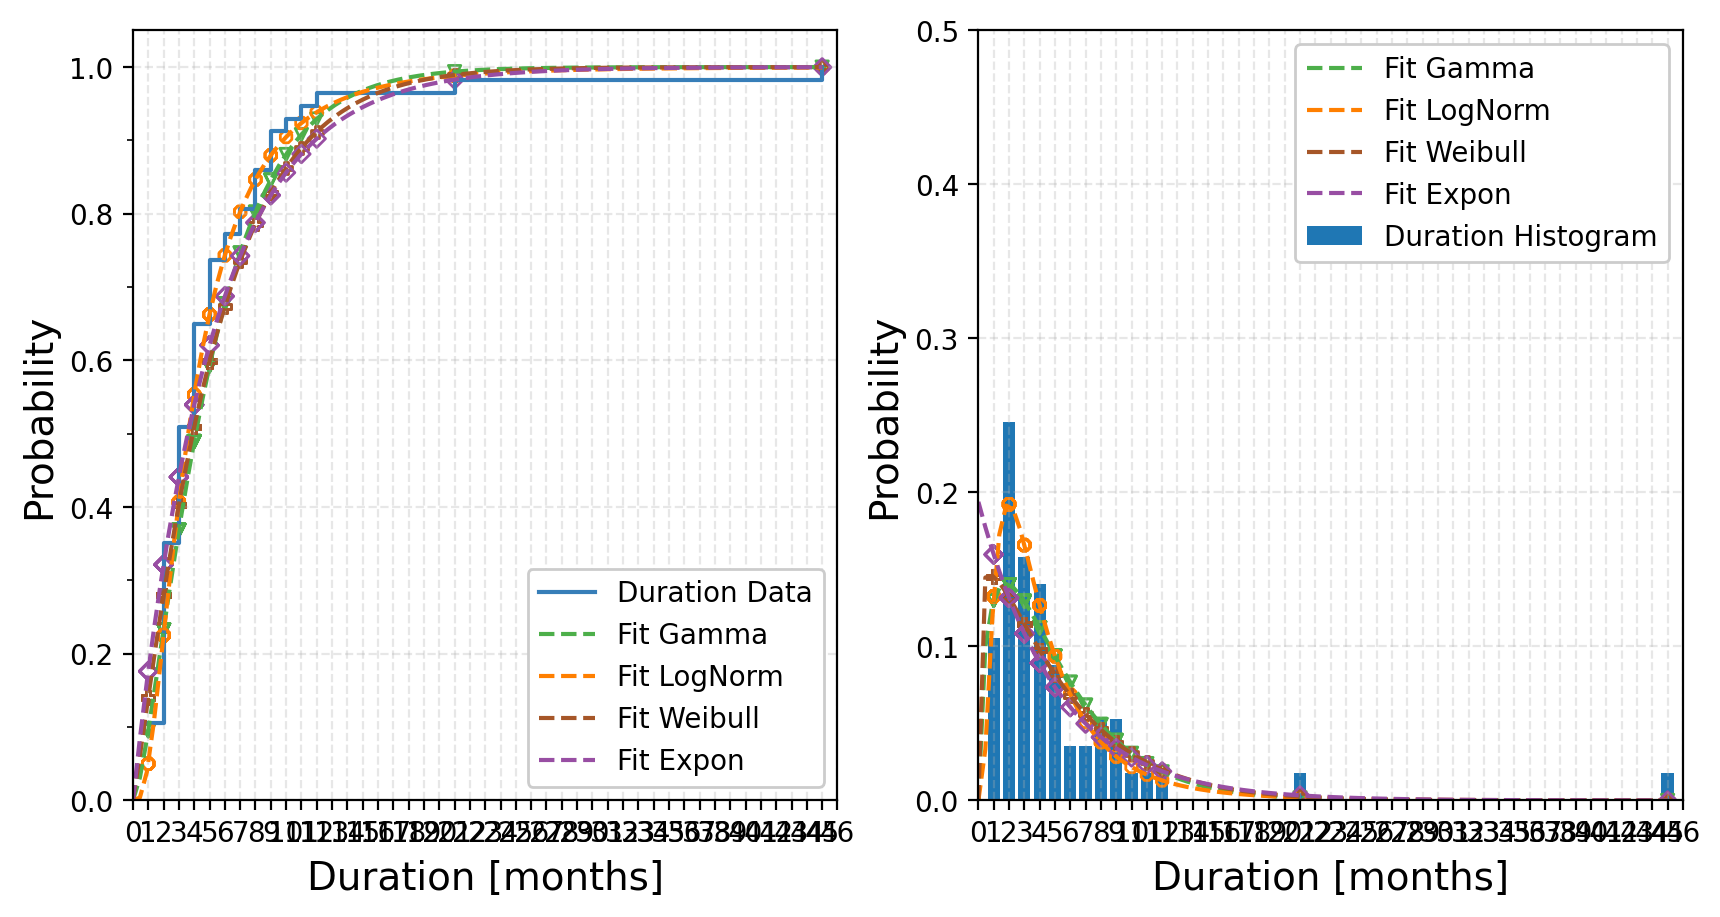

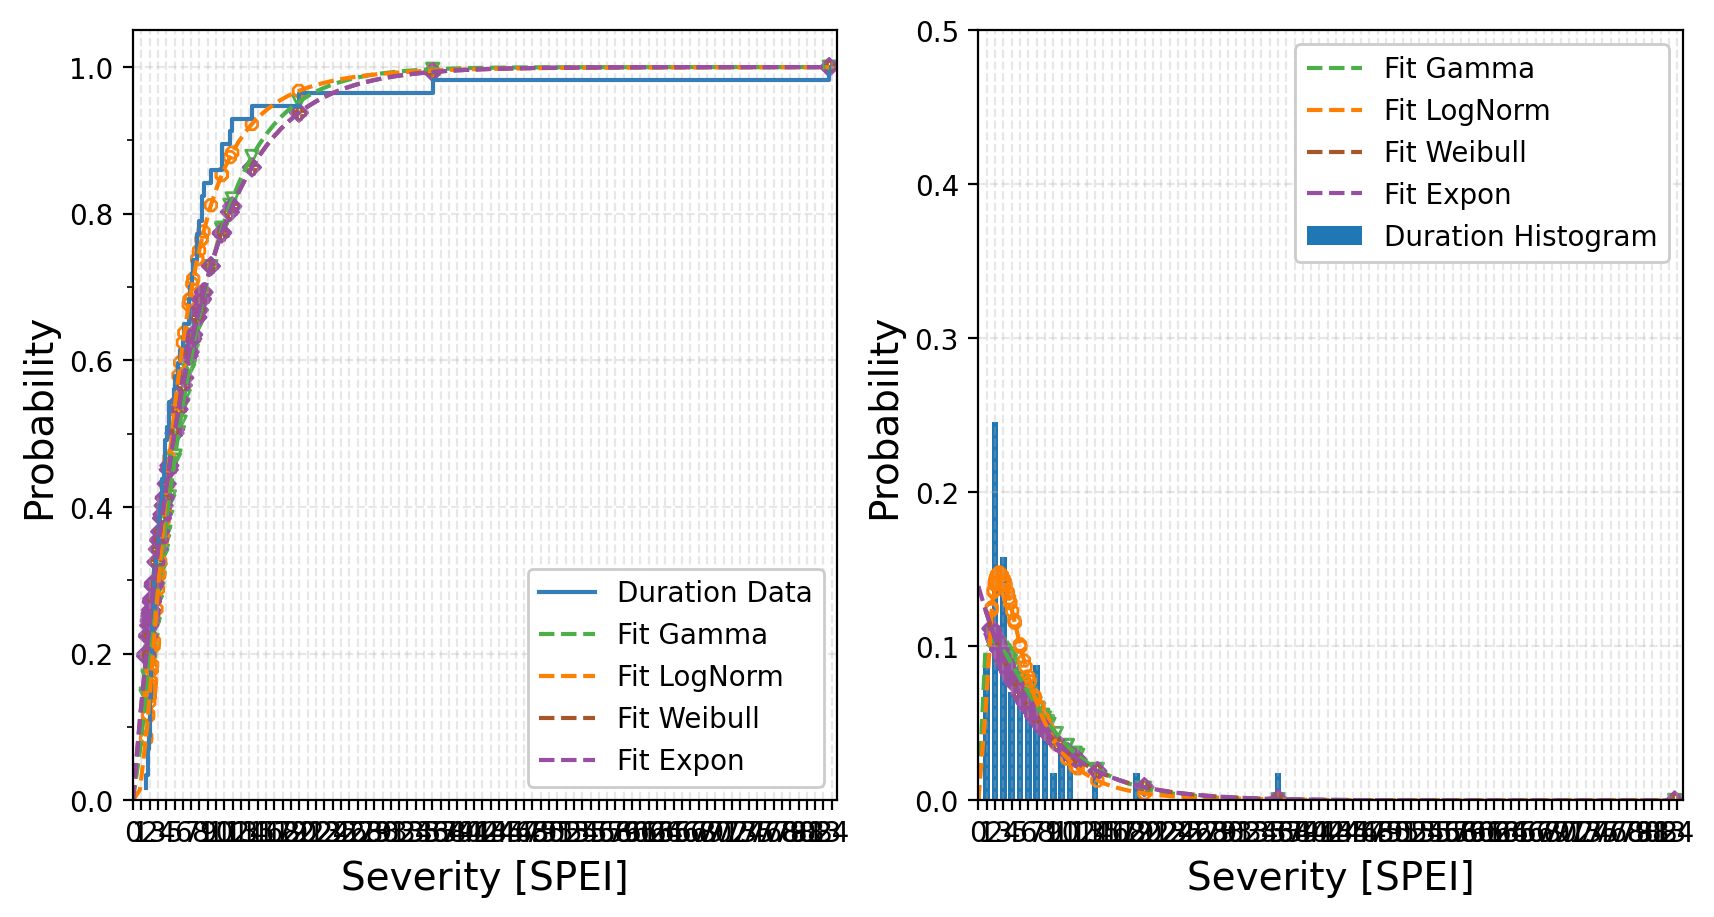

In [14]:
#Define the array for calcultion
index = spei_M1_arr_9
index_name = 'spei_M1_arr_9'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])

### Region 10

number of pairs 61
PearsonR Duration and Severity: PearsonRResult(statistic=0.9747515874207456, pvalue=4.063781498367659e-40)
Duration Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  314.618827     0.006905   0.007213     0.211309
1        Gamma  308.545383     0.016166   0.011656     0.202064
2      LogNorm  296.108785     0.010620   0.084655     0.158122
3      Weibull  313.167142     0.012615   0.035818     0.178538

-----> best fit according to AIC_normal: LogNorm
Severity Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  357.091447     0.007016   0.008438     0.208334
1        Gamma  355.868251     0.008756   0.070025     0.162848
2      LogNorm  336.676465     0.004037   0.237842     0.129345
3      Weibull  358.613669     0.007519   0.025135     0.186288

-----> best fit according to AIC_normal: LogNorm


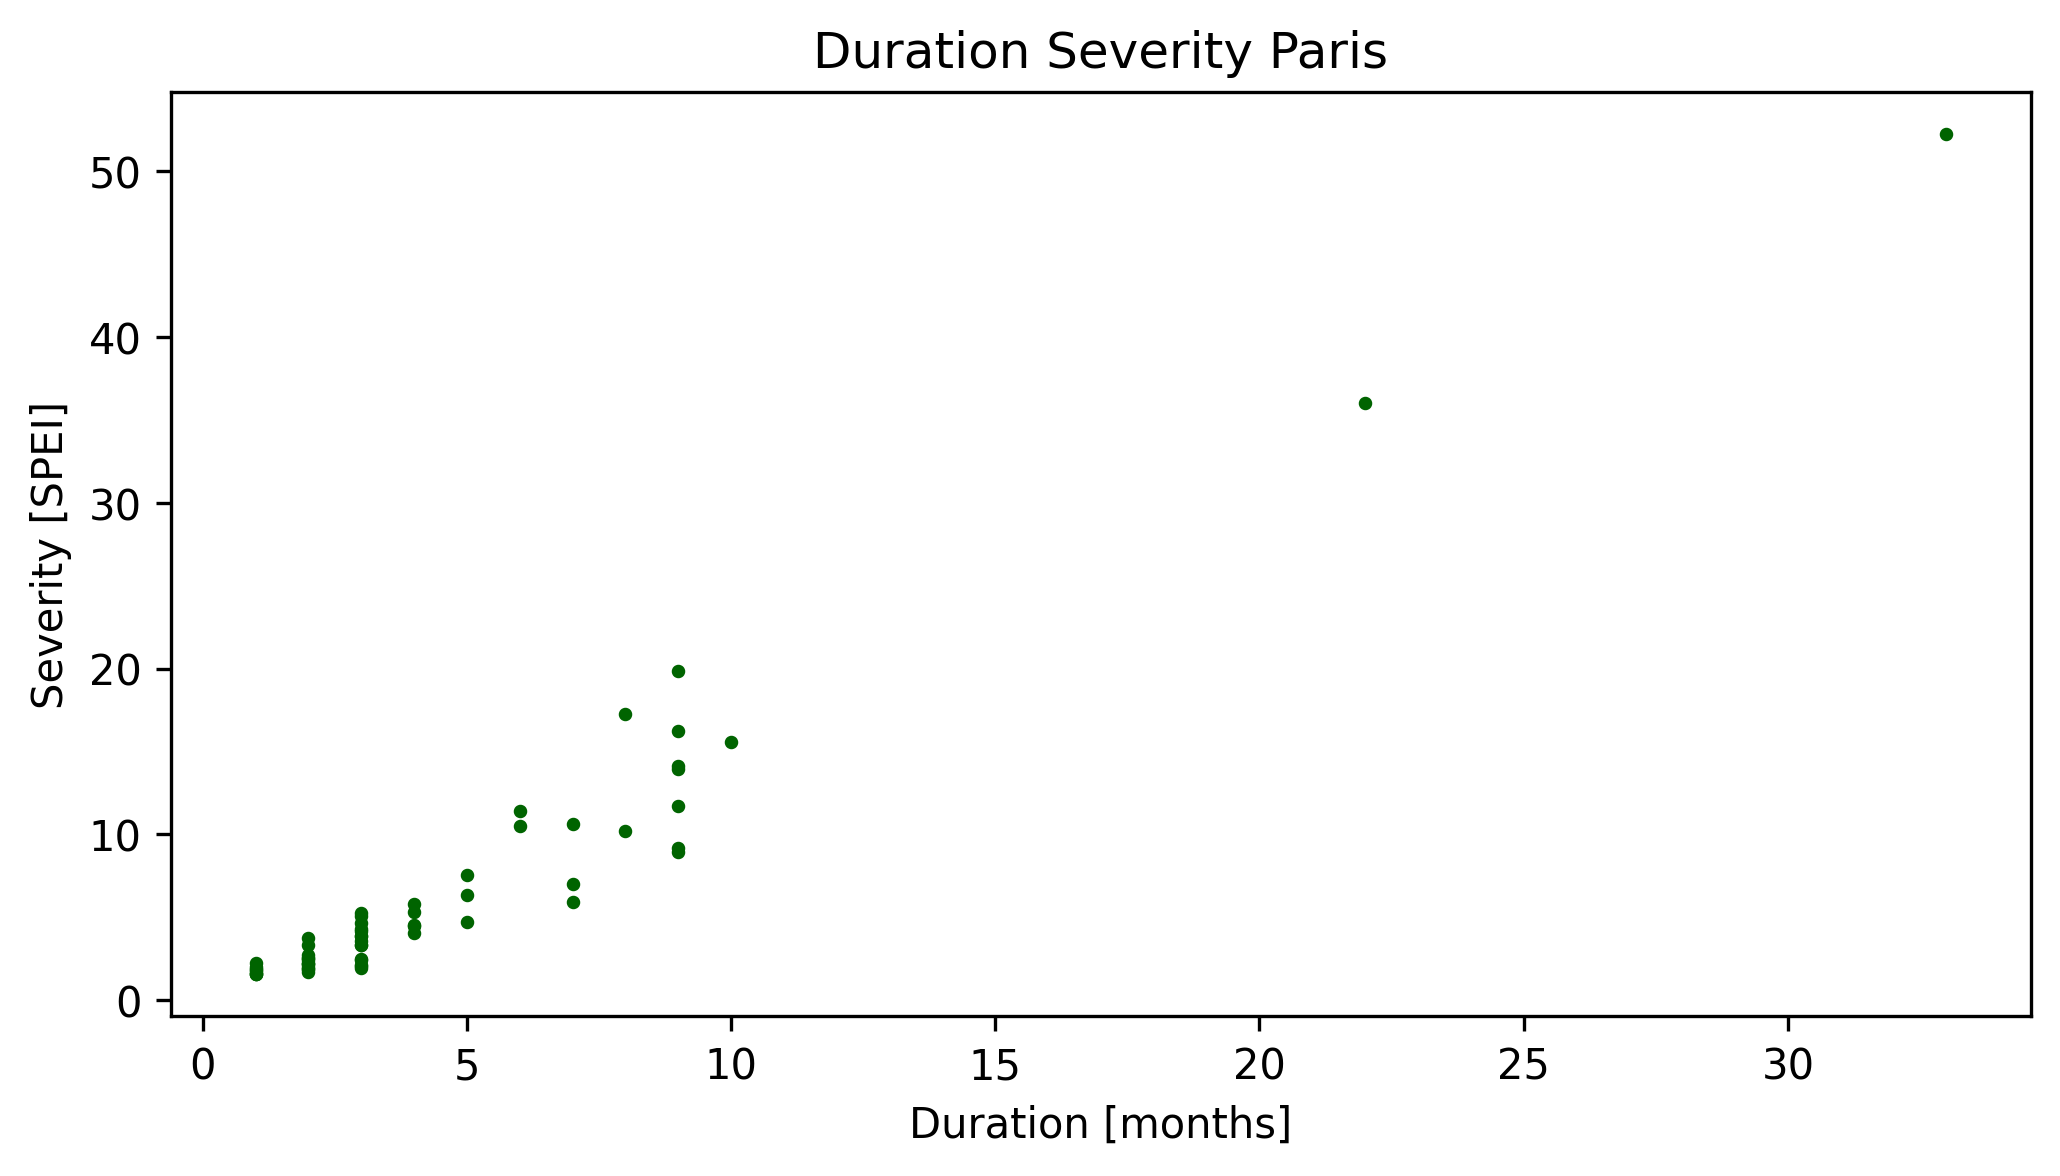

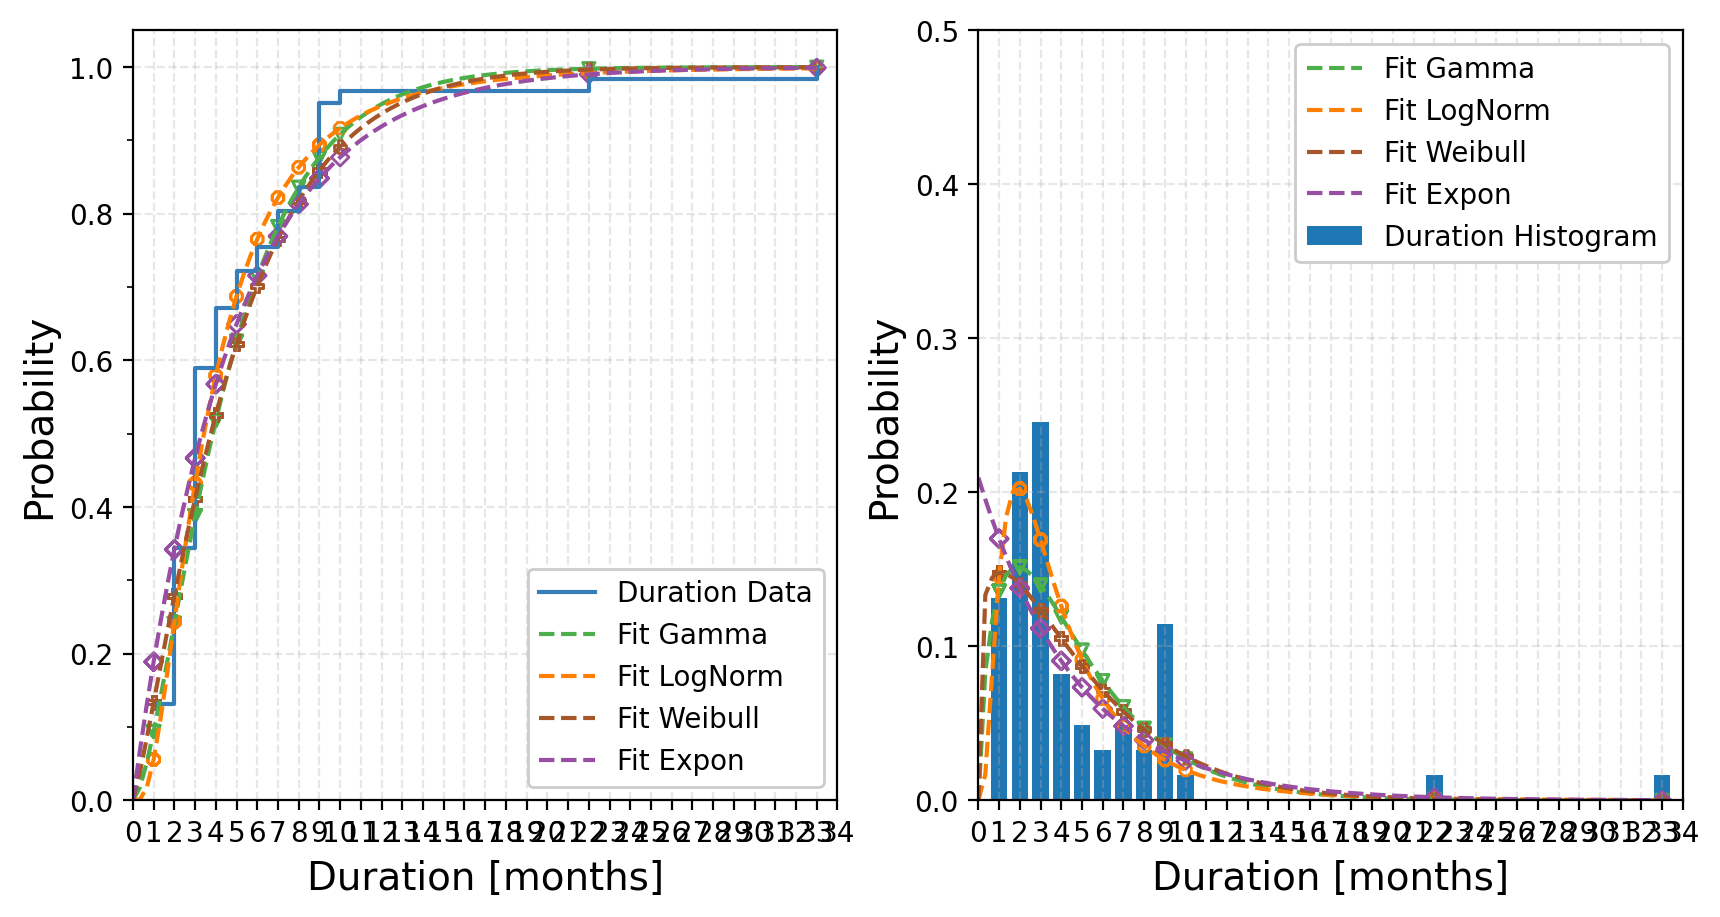

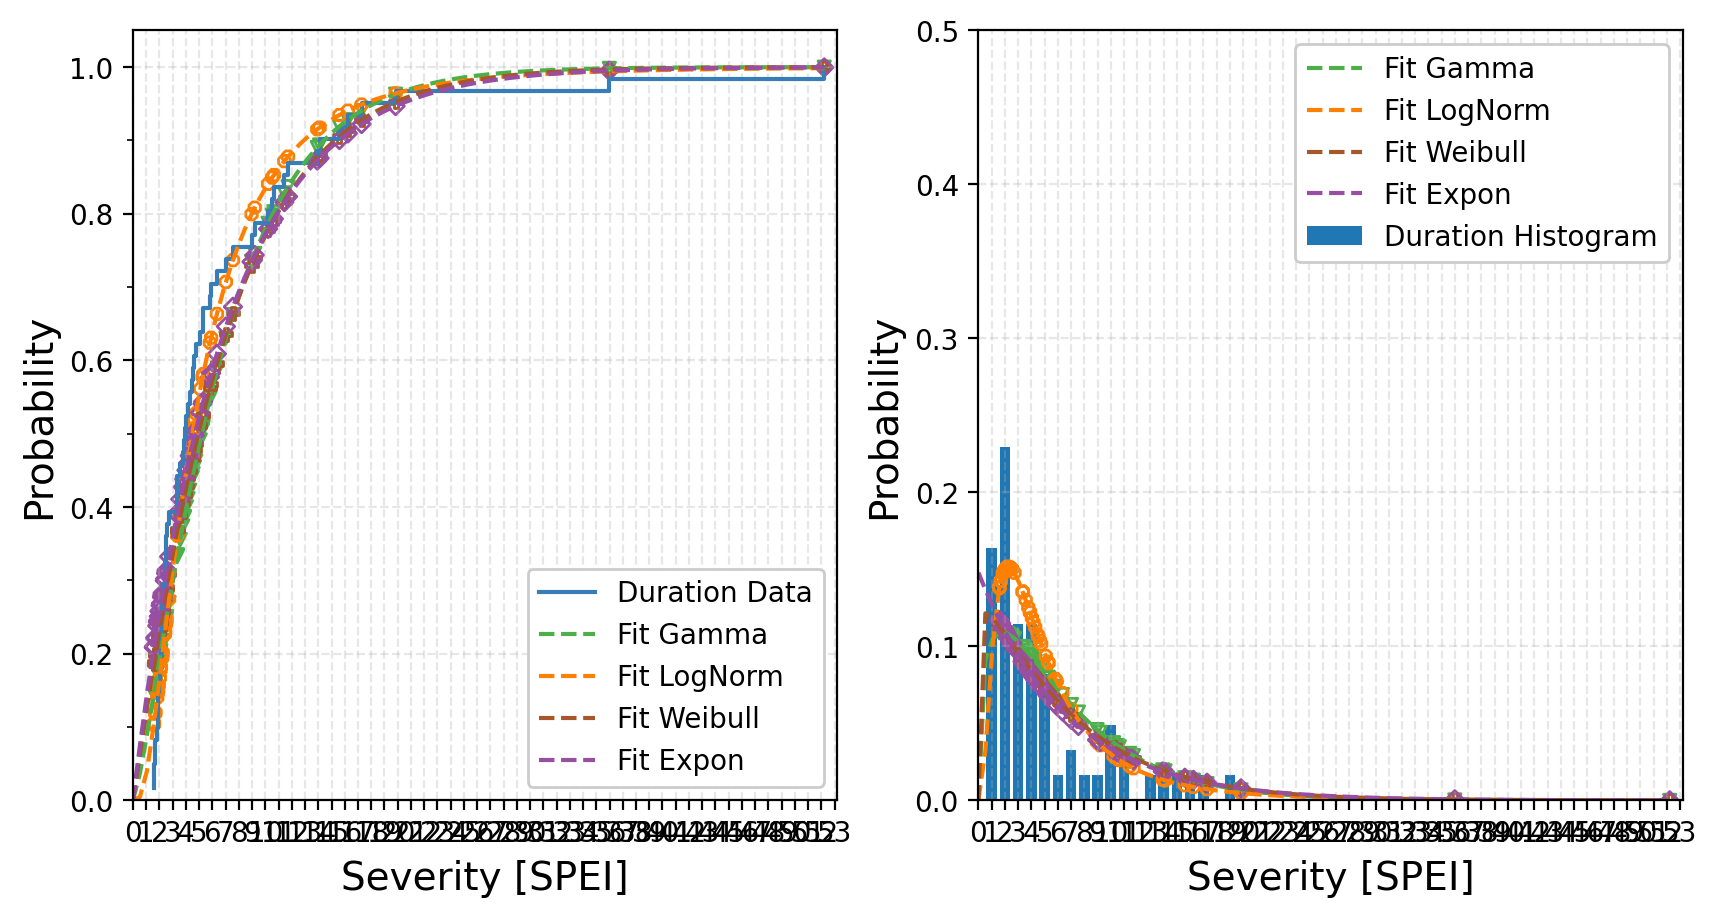

In [15]:
#Define the array for calcultion
index = spei_M1_arr_10
index_name = 'spei_M1_arr_10'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])

### Region 11

number of pairs 72
PearsonR Duration and Severity: PearsonRResult(statistic=0.8293611032319729, pvalue=2.288817435193351e-19)
Duration Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  326.968165     0.003985   0.000005     0.295116
1        Gamma  293.590011     0.010475   0.054914     0.155518
2      LogNorm  293.539491     0.007789   0.120877     0.137211
3      Weibull  296.708220     0.011245   0.068854     0.150498

-----> best fit according to AIC_normal: LogNorm
Severity Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  369.228294     0.012449   0.000027     0.274867
1        Gamma  343.101836     0.005394   0.073933     0.148884
2      LogNorm  333.543583     0.002779   0.209402     0.122838
3      Weibull  350.099602     0.005960   0.117666     0.137876

-----> best fit according to AIC_normal: LogNorm


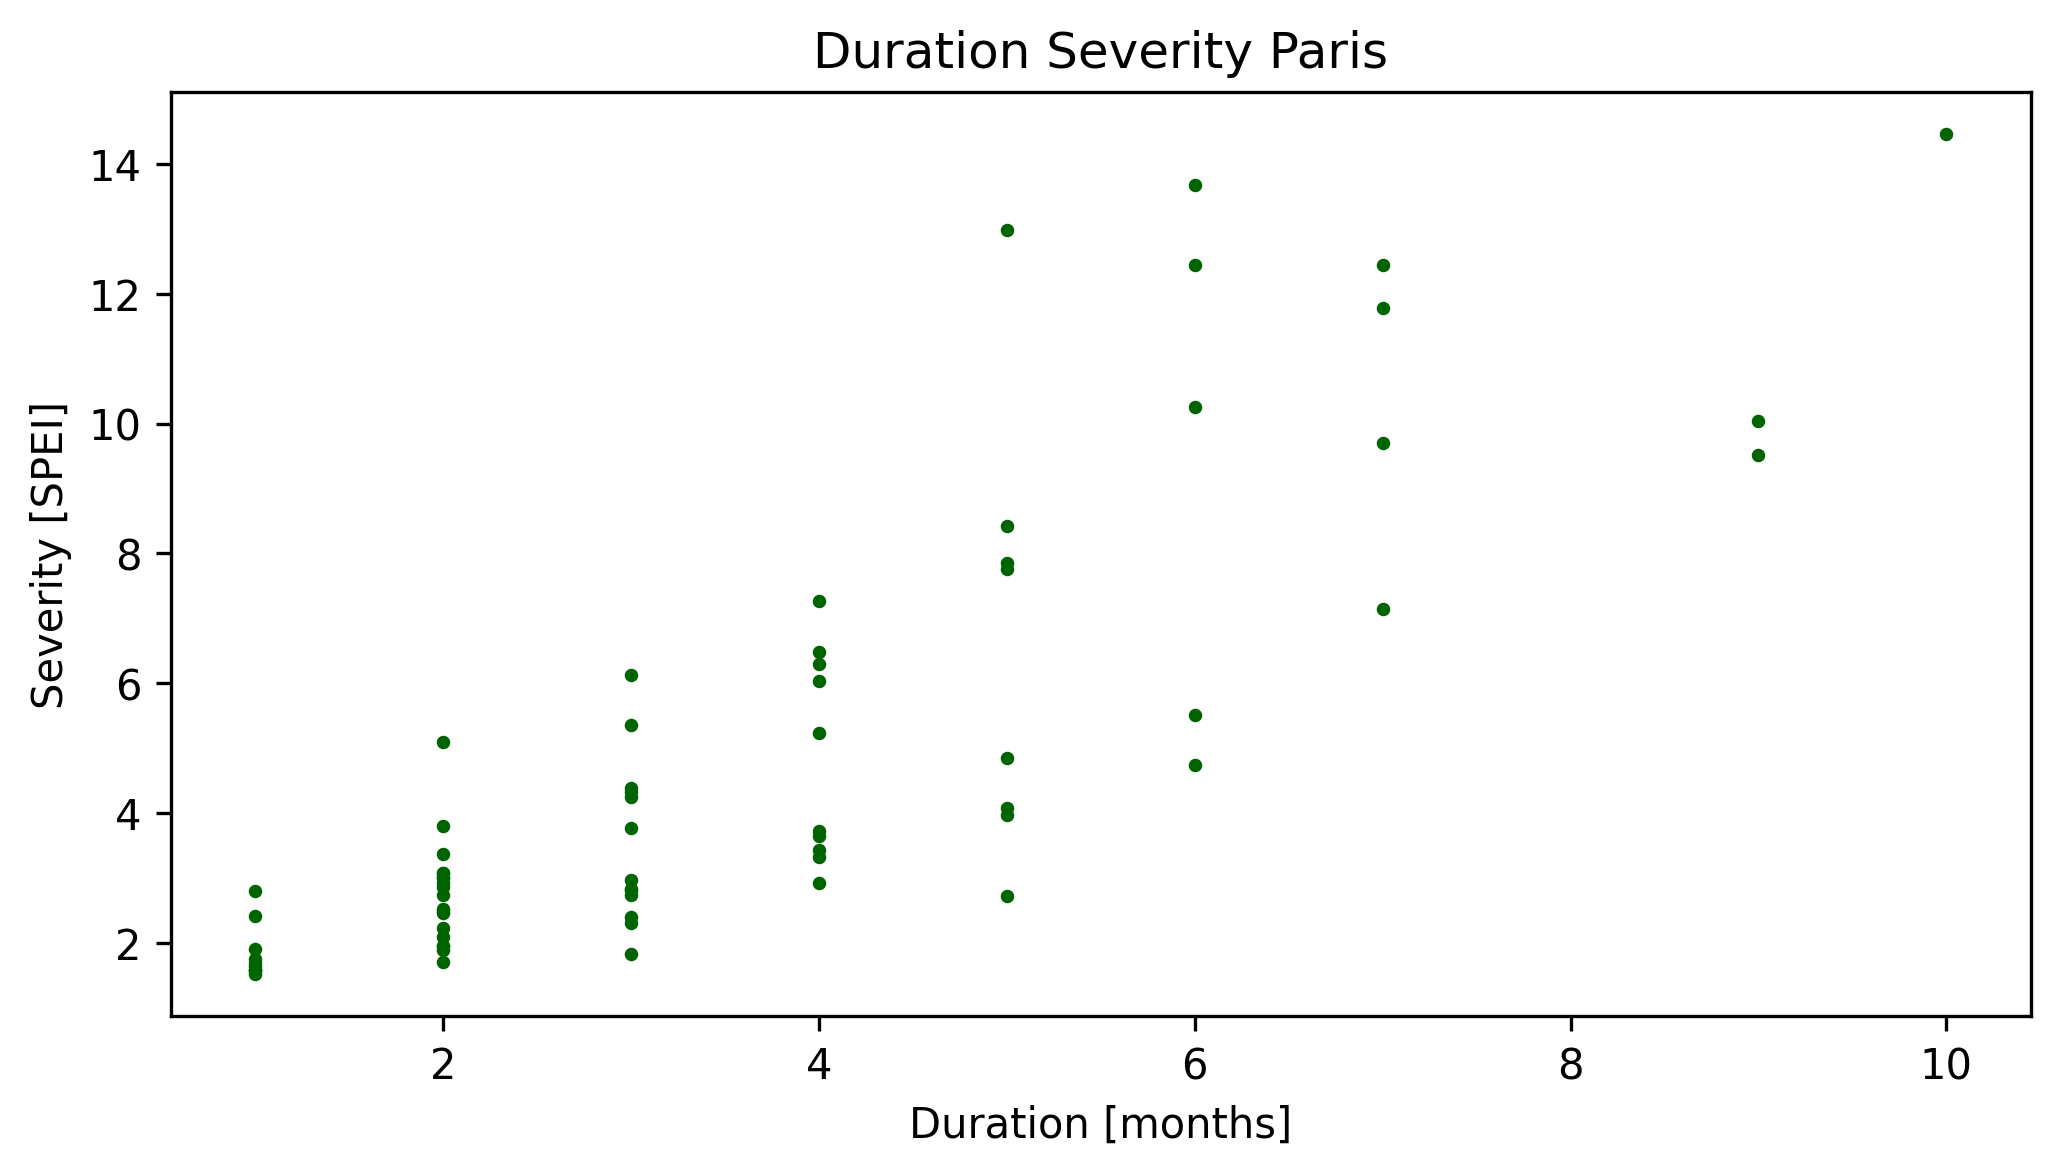

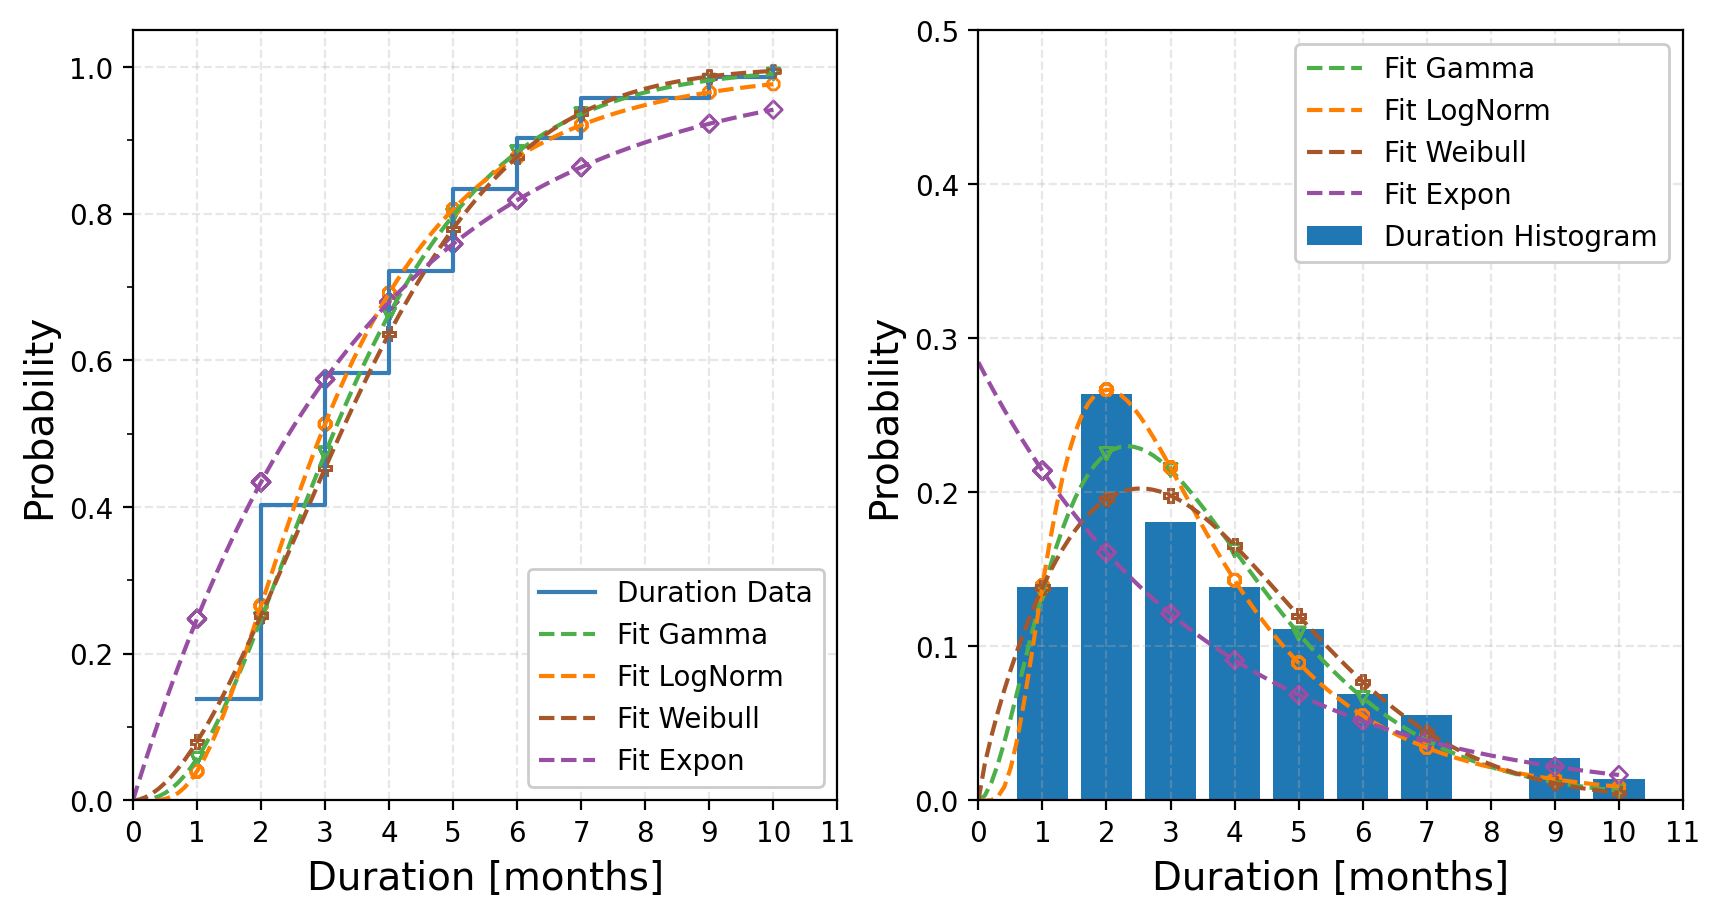

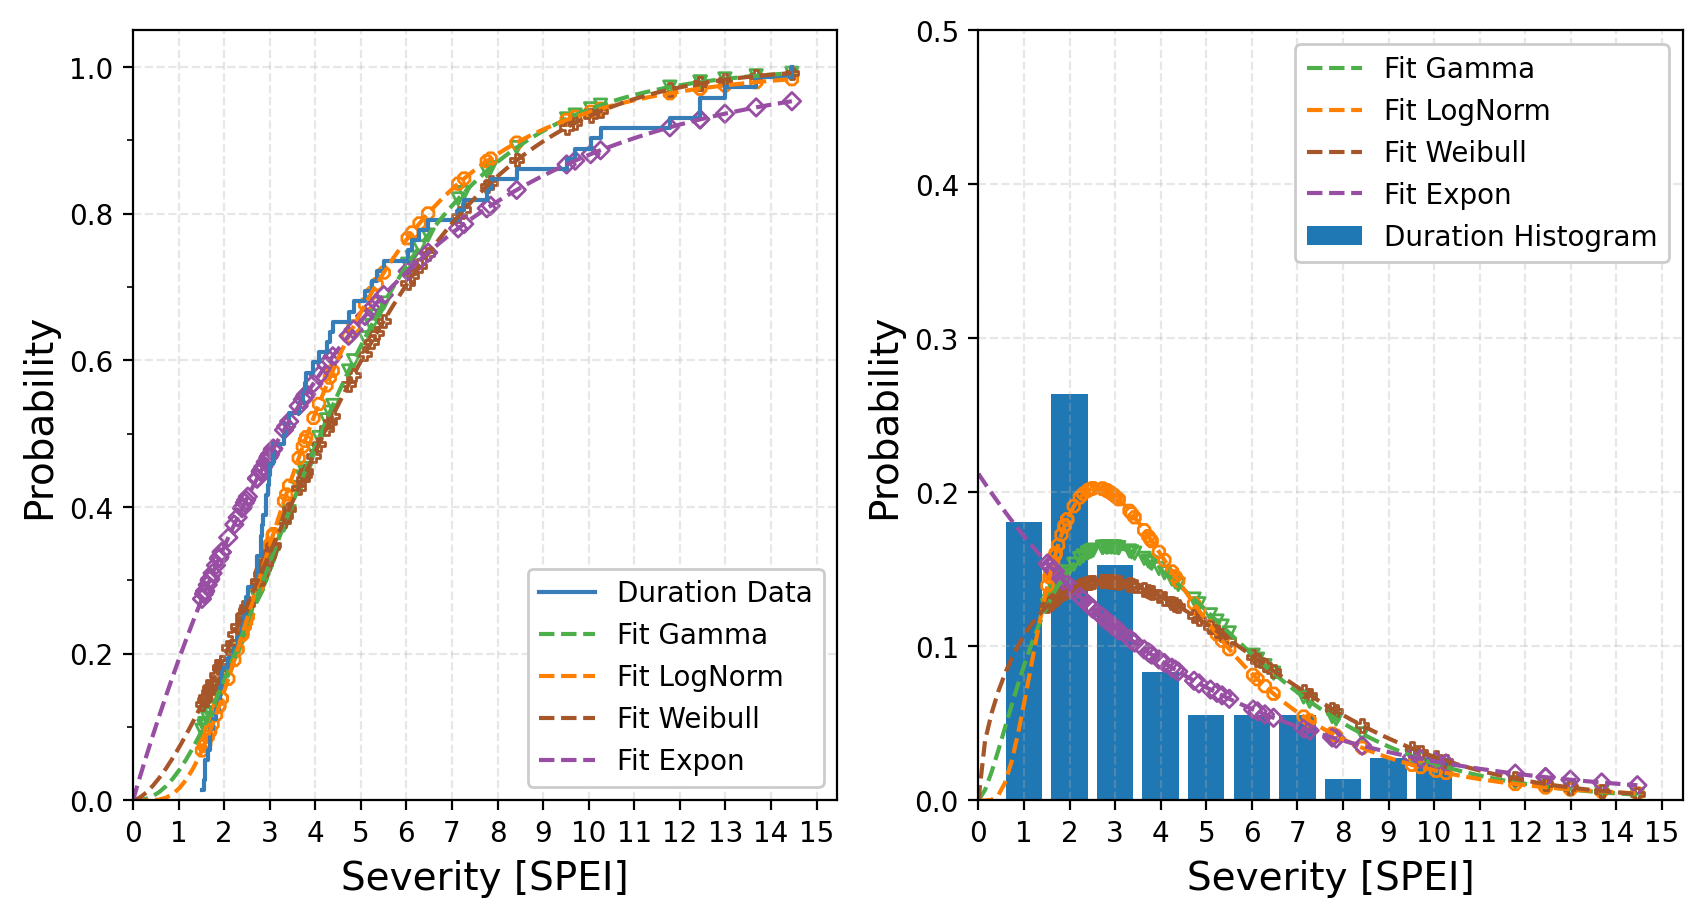

In [16]:
#Define the array for calcultion
index = spei_M1_arr_11
index_name = 'spei_M1_arr_11'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])

### Region 12

number of pairs 60
PearsonR Duration and Severity: PearsonRResult(statistic=0.905910525504619, pvalue=2.6023389757354824e-23)
Duration Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  300.246232     0.003947   0.012315     0.202613
1        Gamma  284.713747     0.005098   0.507034     0.103609
2      LogNorm  285.175338     0.004516   0.144870     0.145060
3      Weibull  287.450988     0.005015   0.559262     0.099445

-----> best fit according to AIC_normal: Gamma
Severity Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  334.673008     0.007515   0.001761     0.238243
1        Gamma  325.479612     0.004300   0.268229     0.126572
2      LogNorm  310.100198     0.001918   0.489105     0.105079
3      Weibull  332.032912     0.004646   0.056105     0.169568

-----> best fit according to AIC_normal: LogNorm


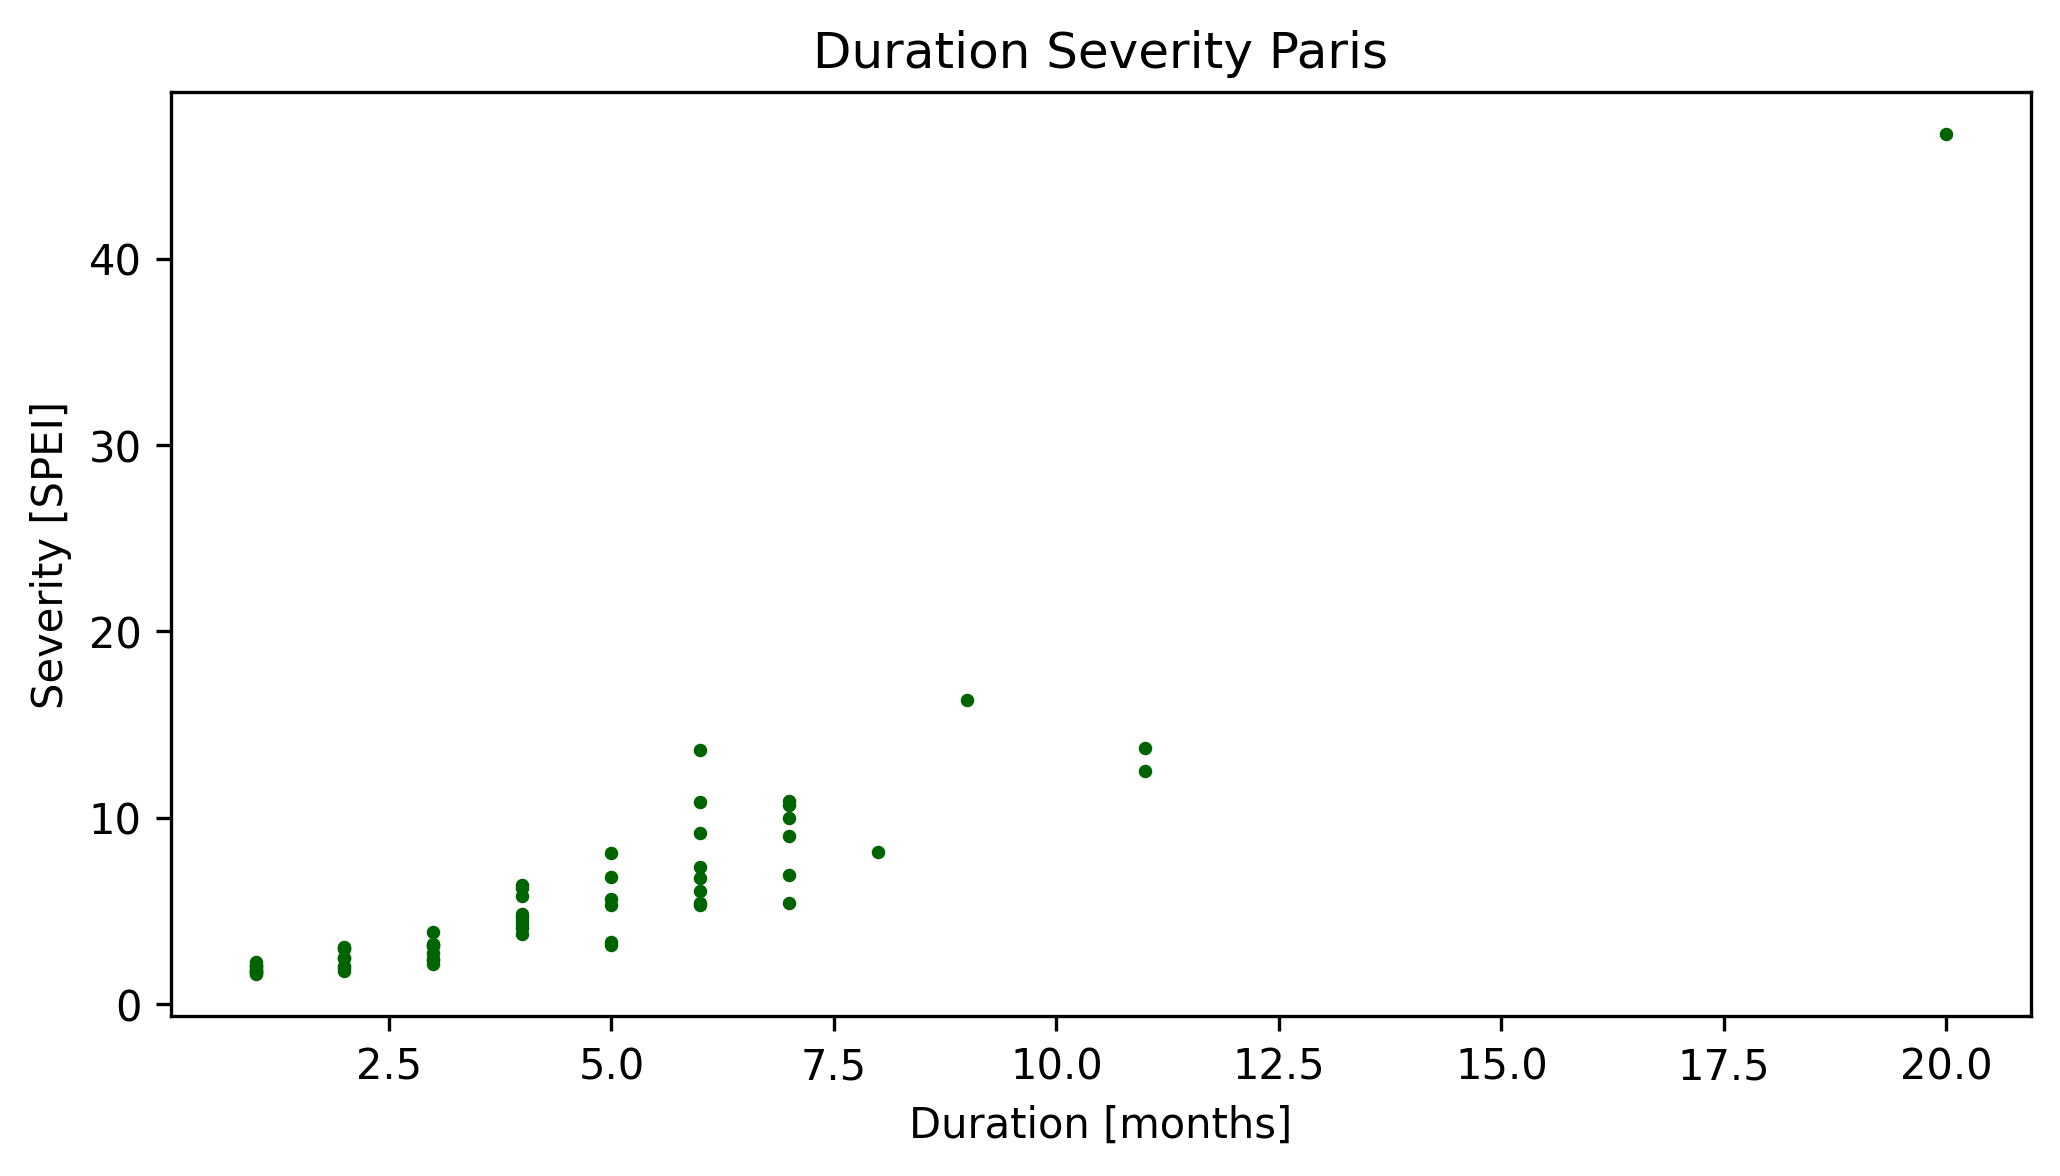

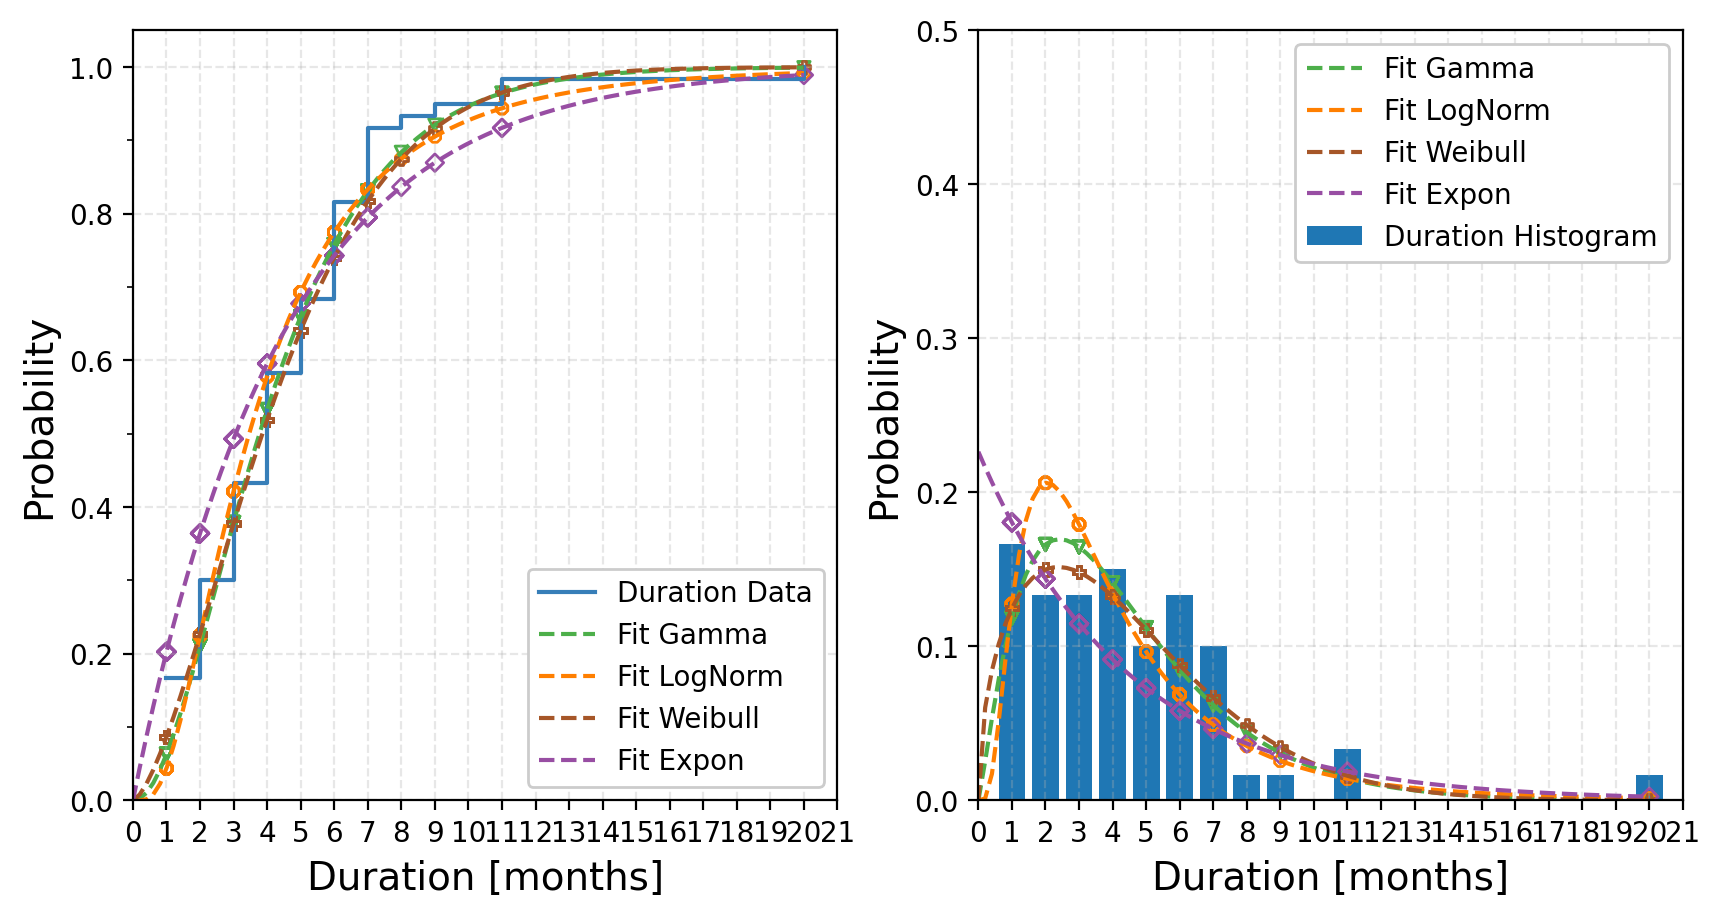

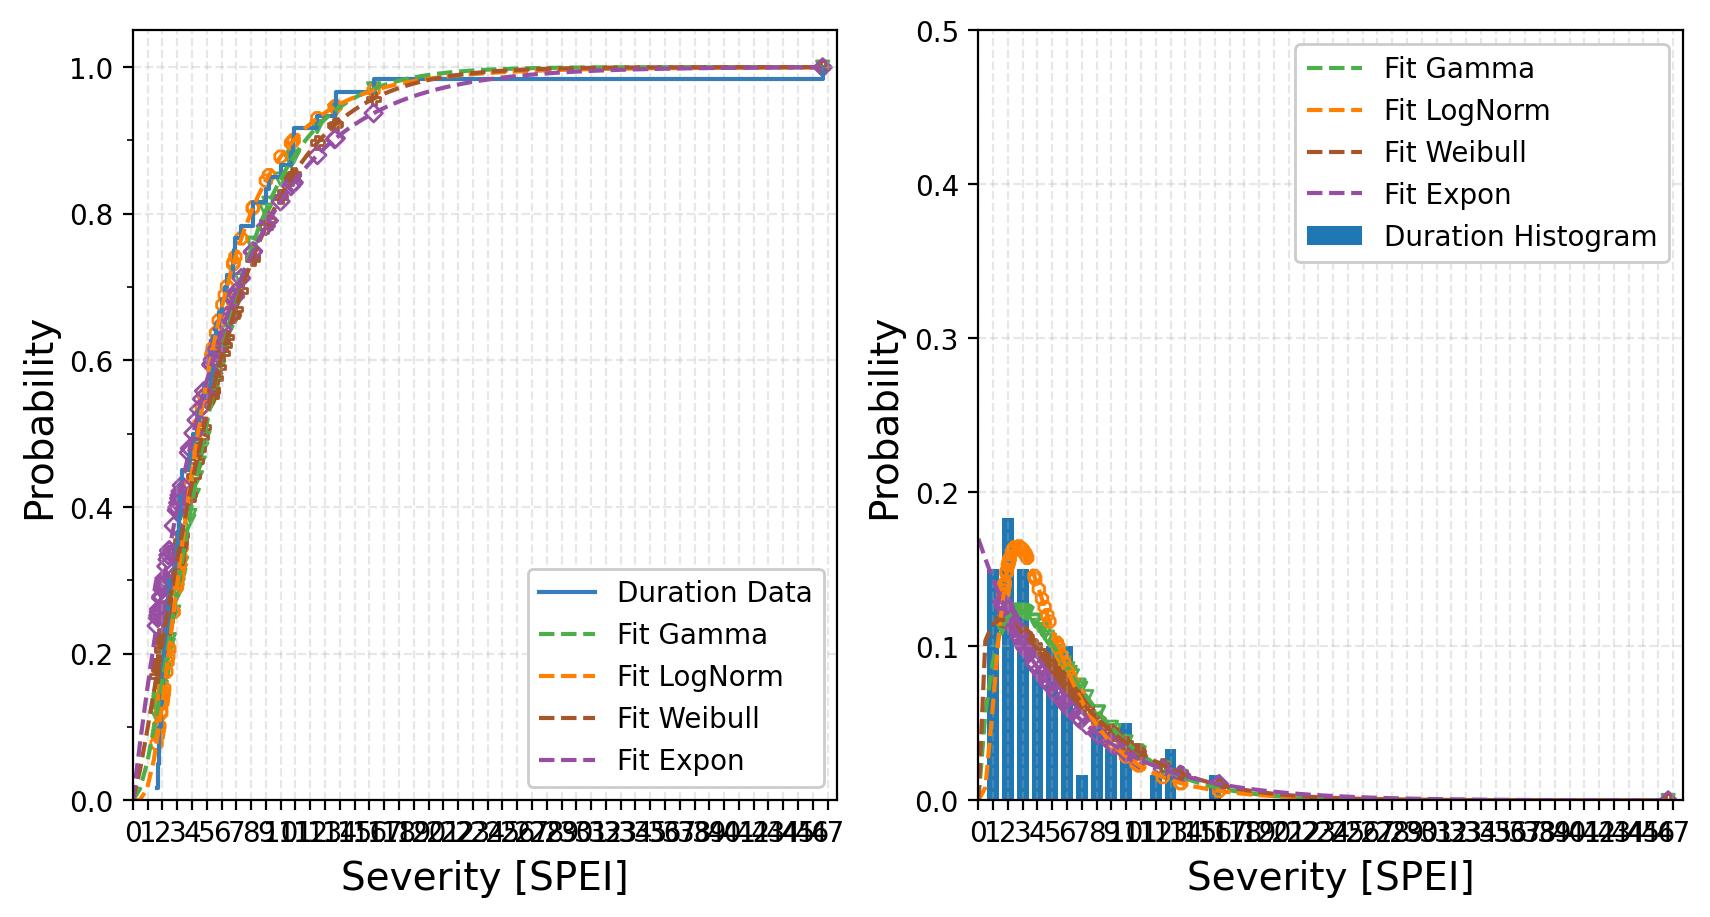

In [17]:
#Define the array for calcultion
index = spei_M1_arr_12
index_name = 'spei_M1_arr_12'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])

### Region 13

number of pairs 73
PearsonR Duration and Severity: PearsonRResult(statistic=0.9348597418173975, pvalue=1.1773202100536563e-33)
Duration Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  319.312365     0.003471   0.000047     0.266056
1        Gamma  296.581442     0.014229   0.049385     0.156751
2      LogNorm  289.898371     0.010824   0.093244     0.142524
3      Weibull  302.989678     0.012849   0.095726     0.141905

-----> best fit according to AIC_normal: LogNorm
Severity Fit:


Distribution  AIC_normal  MSE_adapted     KS_pValue  KS_Distance
0        Expon  336.368538     0.020548  4.798895e-08     0.340243
1        Gamma  294.115035     0.003458  3.223828e-01     0.109441
2      LogNorm  282.381289     0.002107  6.035717e-01     0.087253
3      Weibull  307.346654     0.004811  2.880731e-02     0.167866

-----> best fit according to AIC_normal: LogNorm


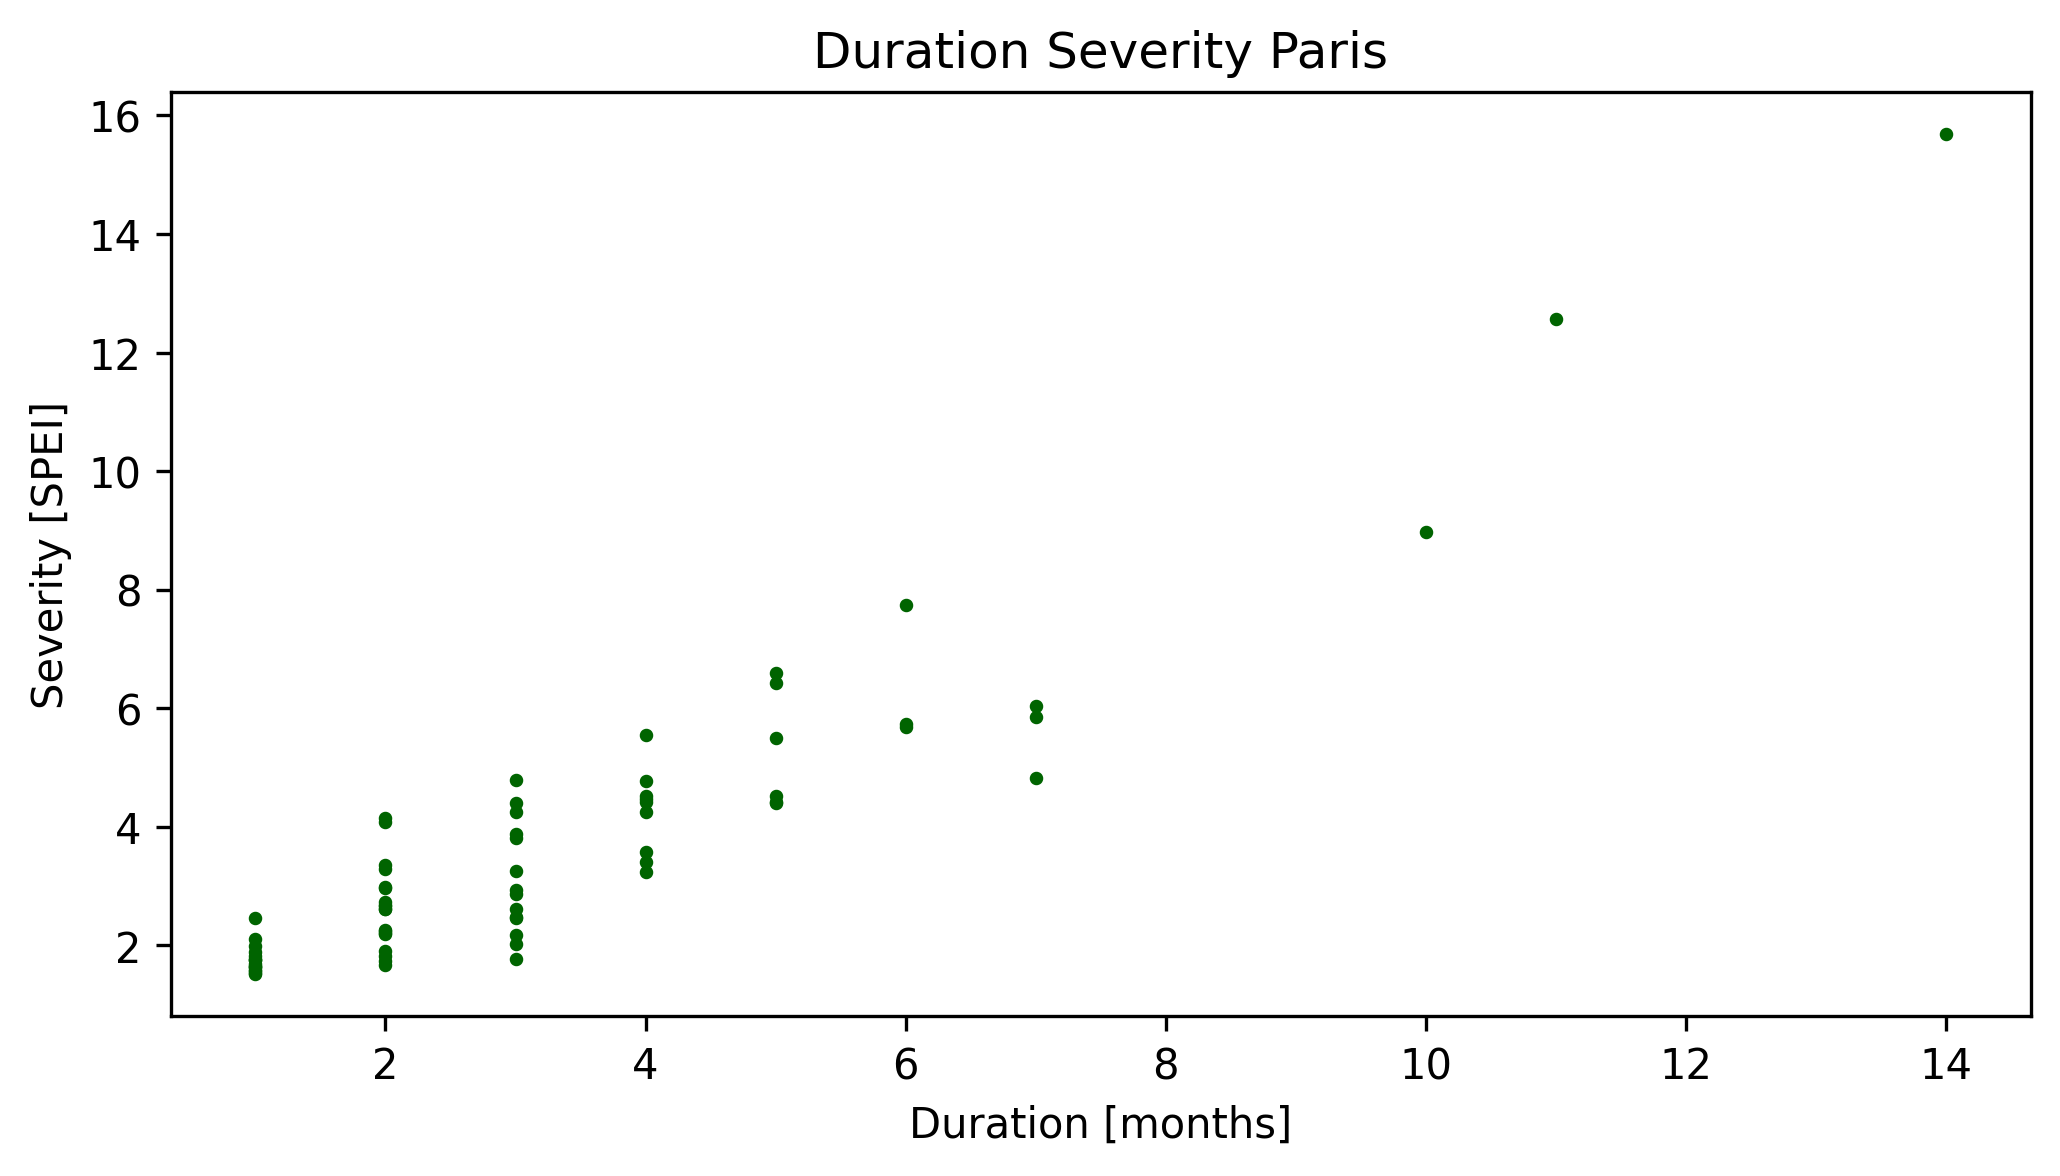

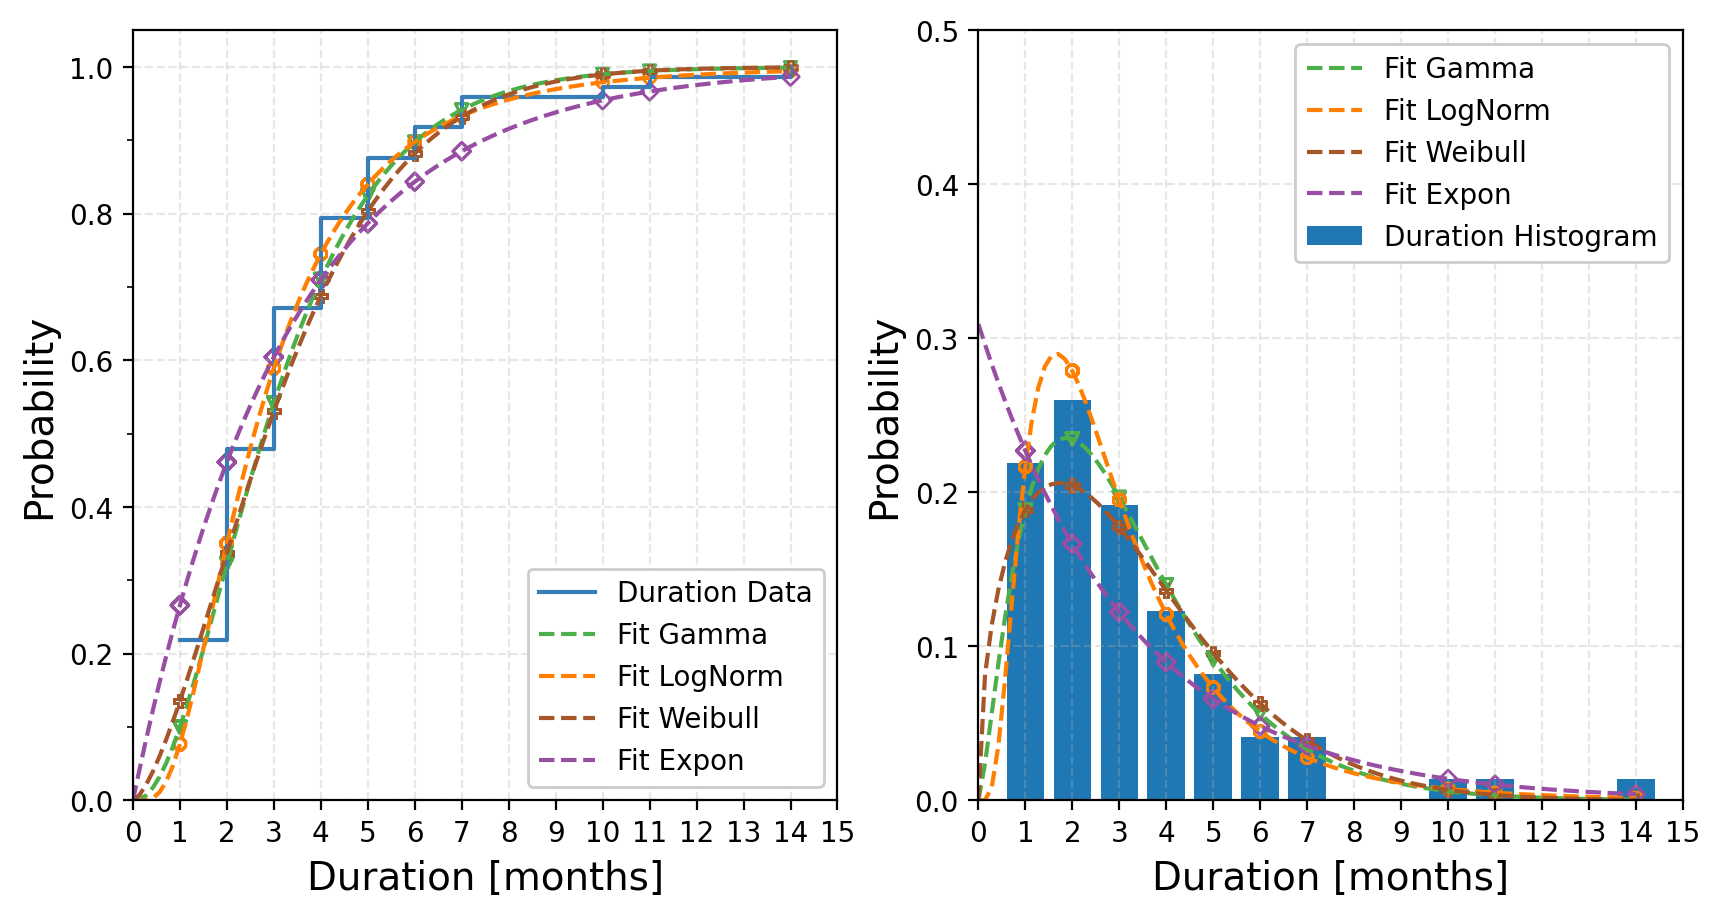

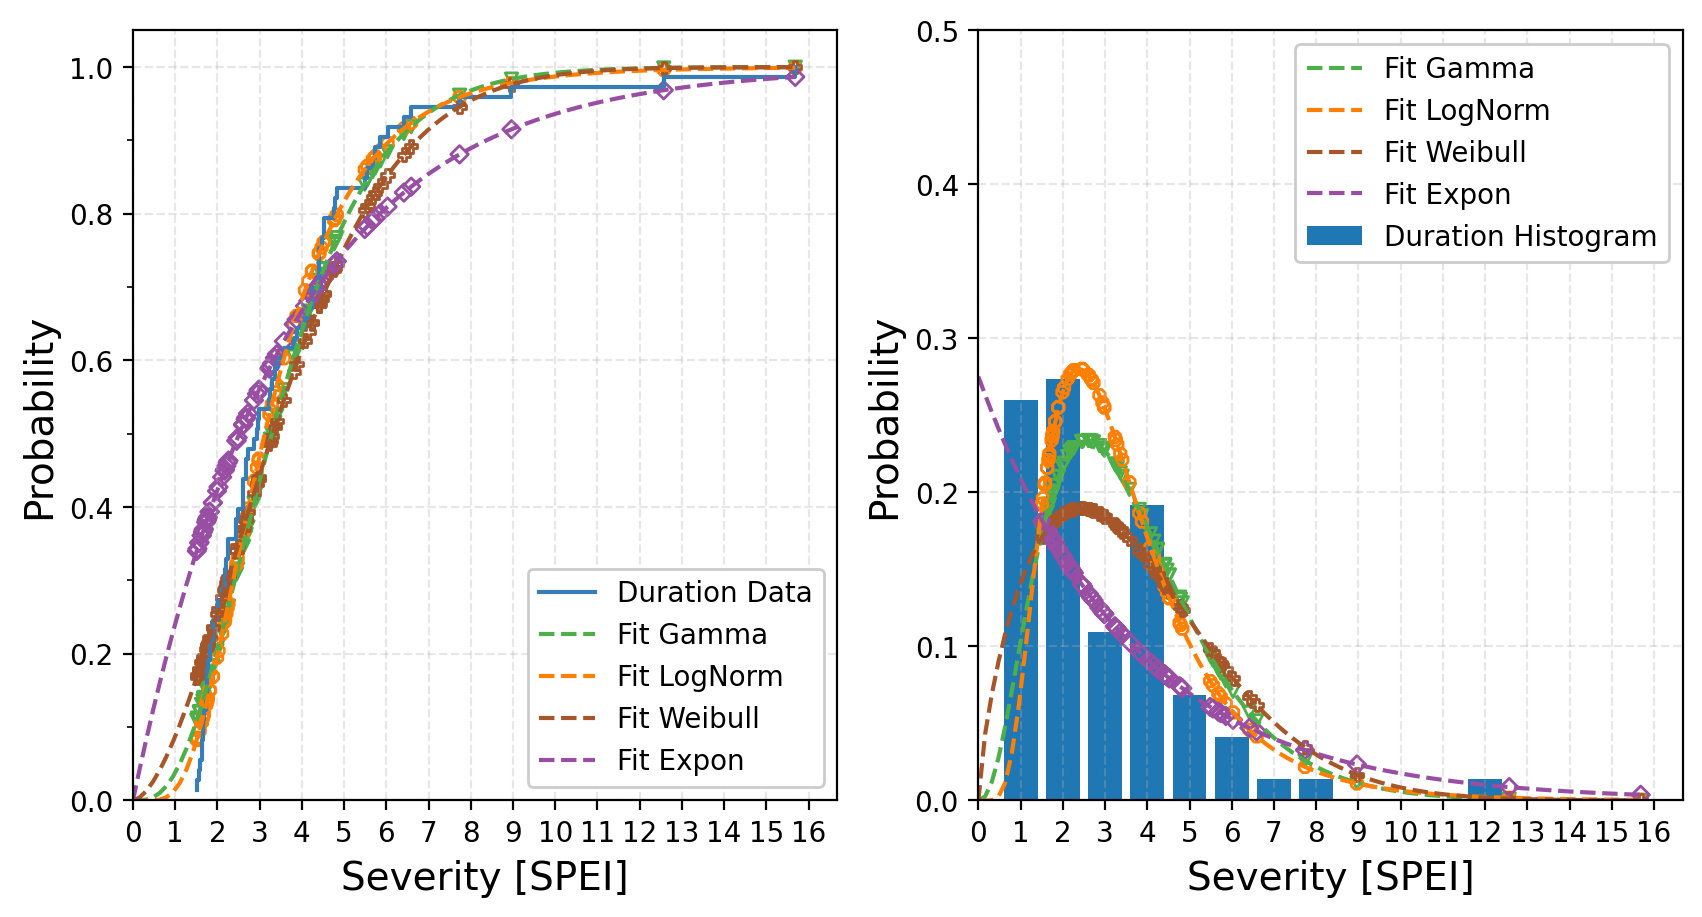

In [18]:
#Define the array for calcultion
index = spei_M1_arr_13
index_name = 'spei_M1_arr_13'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])

### Region 14

number of pairs 62
PearsonR Duration and Severity: PearsonRResult(statistic=0.9764459032686001, pvalue=1.1471150714470377e-41)
Duration Fit:


/rds/general/user/nmerz/home/.conda/envs/thesis/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2509: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  317.727421     0.012340   0.017892     0.191891
1        Gamma  317.329576     0.019409   0.007294     0.209422
2      LogNorm  295.545360     0.010792   0.226780     0.129778
3      Weibull  319.684508     0.013426   0.020585     0.189002

-----> best fit according to AIC_normal: LogNorm
Severity Fit:


Distribution  AIC_normal  MSE_adapted  KS_pValue  KS_Distance
0        Expon  335.046130     0.015784   0.000864     0.245996
1        Gamma  333.623951     0.017079   0.001839     0.233721
2      LogNorm  297.343798     0.007075   0.117490     0.148414
3      Weibull  337.044507     0.016048   0.000798     0.247252

-----> best fit according to AIC_normal: LogNorm


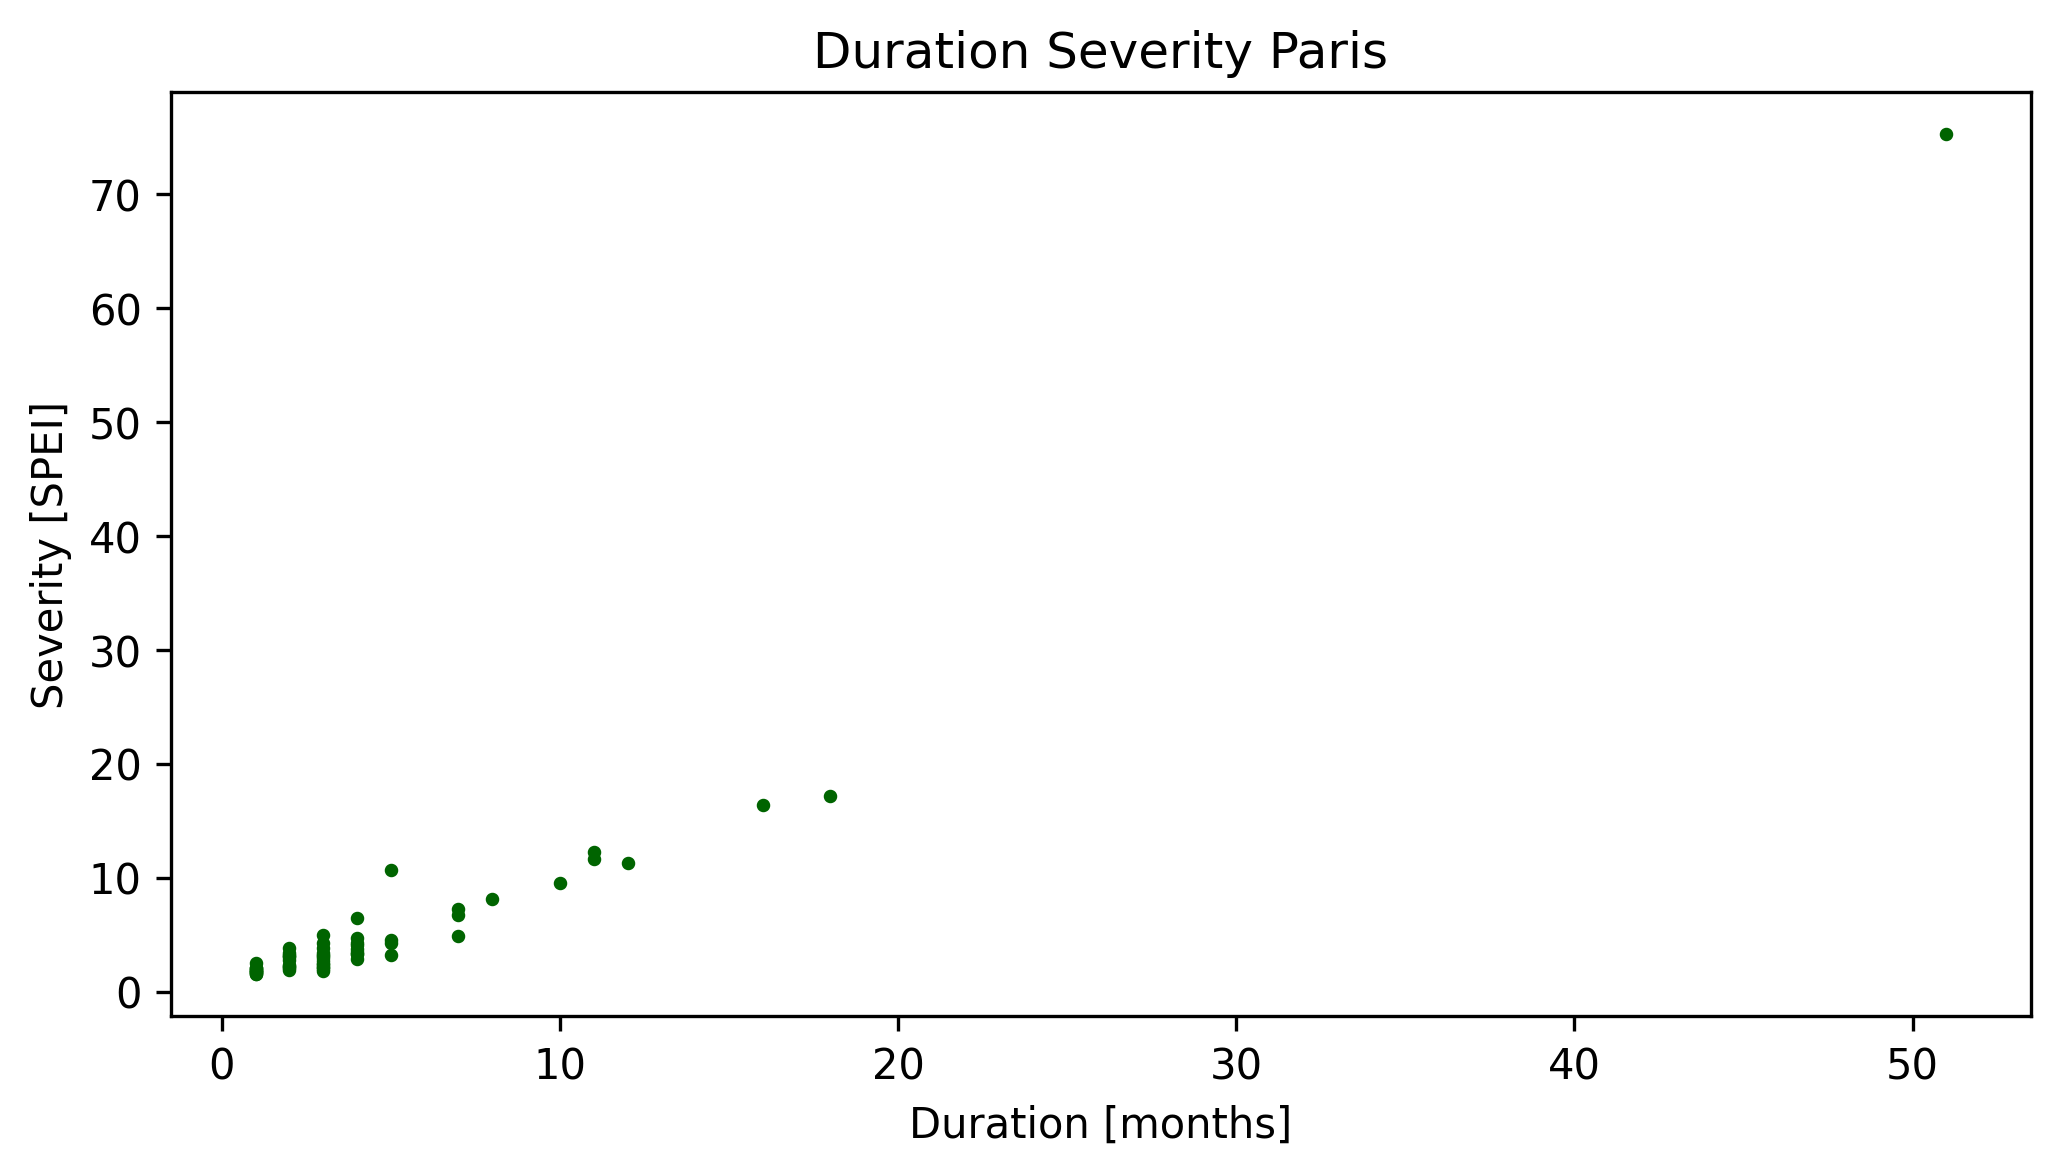

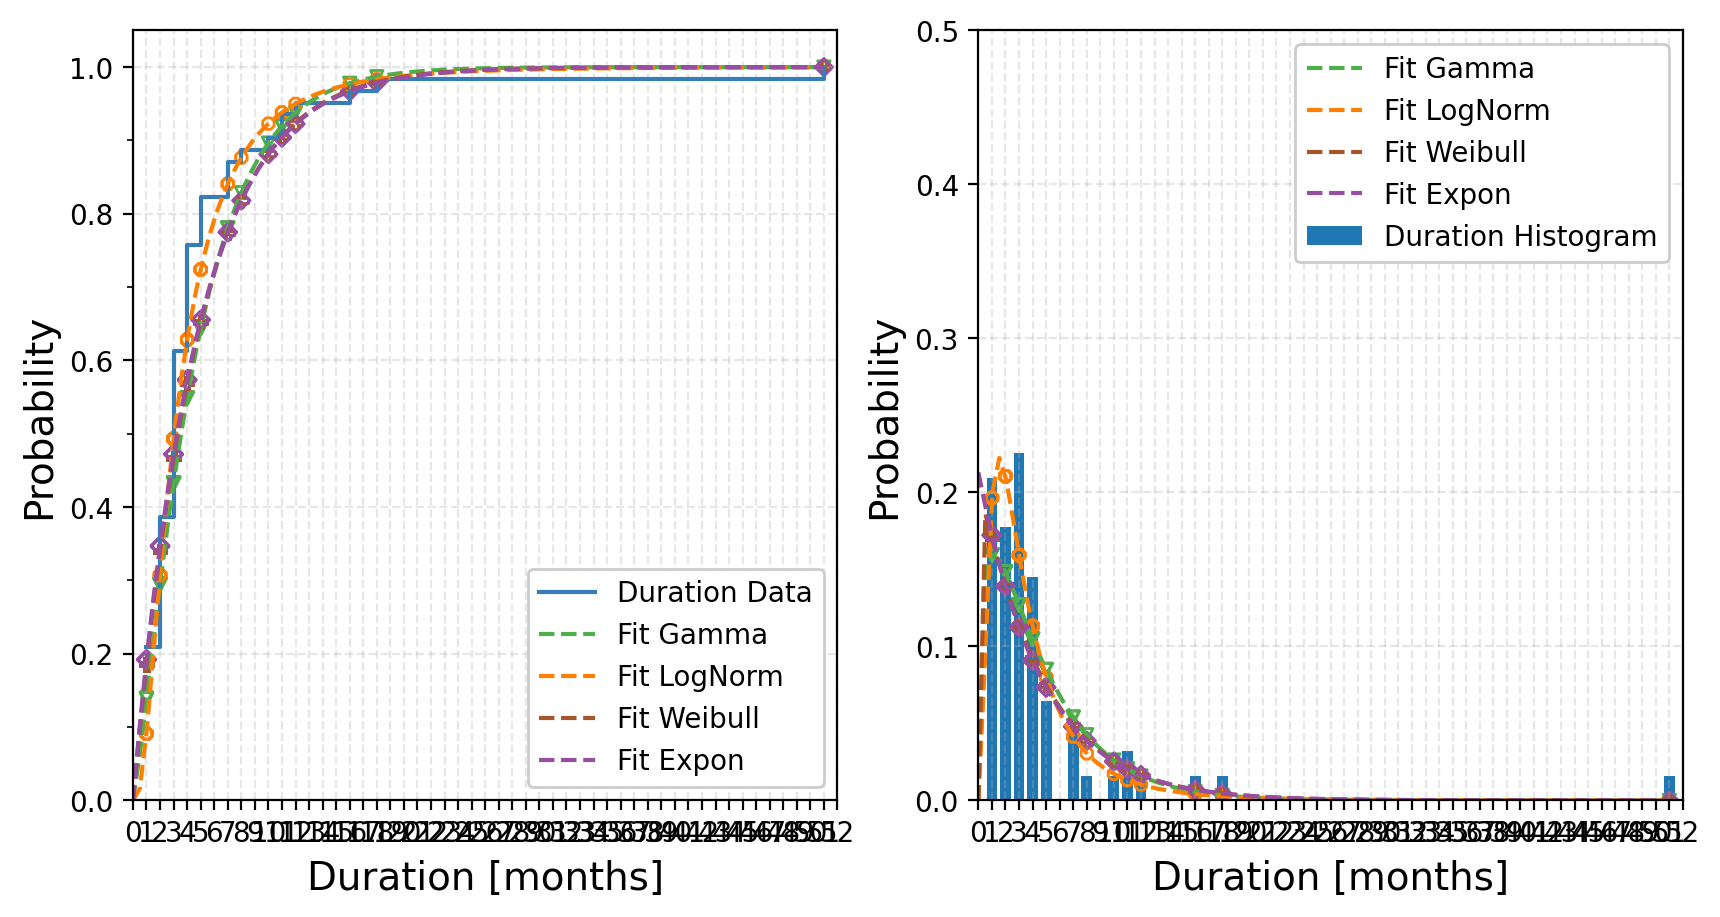

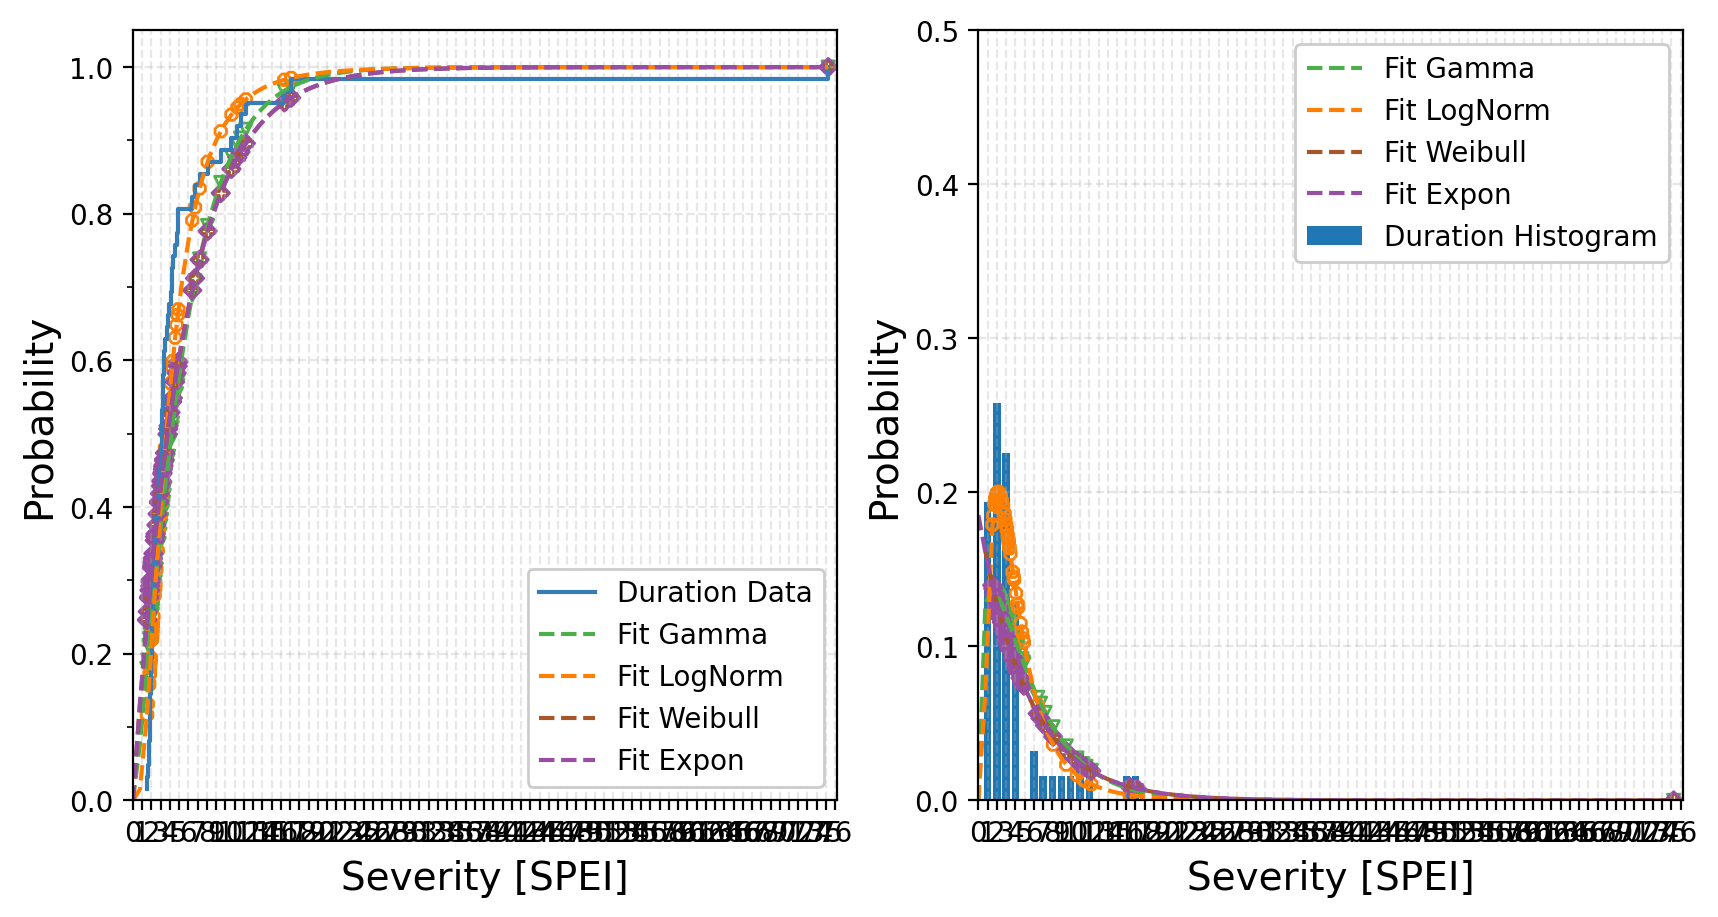

In [19]:
#Define the array for calcultion
index = spei_M1_arr_14
index_name = 'spei_M1_arr_14'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])

### Region 15

number of pairs 81
PearsonR Duration and Severity: PearsonRResult(statistic=0.8810652817575763, pvalue=2.0838016864804307e-27)
Duration Fit:


Distribution  AIC_normal  MSE_adapted     KS_pValue  KS_Distance
0        Expon  333.068085     0.003459  8.013847e-07     0.296842
1        Gamma  309.205692     0.020887  1.022050e-03     0.213426
2      LogNorm  303.611429     0.020236  3.445606e-04     0.228189
3      Weibull  314.197210     0.018738  5.590856e-03     0.187963

-----> best fit according to AIC_normal: LogNorm
Severity Fit:


Distribution  AIC_normal  MSE_adapted     KS_pValue  KS_Distance
0        Expon  361.724773     0.022815  7.805261e-10     0.358640
1        Gamma  308.782605     0.004757  5.209648e-02     0.147847
2      LogNorm  296.846079     0.003381  2.029230e-01     0.116757
3      Weibull  323.051686     0.005633  1.747492e-02     0.168693

-----> best fit according to AIC_normal: LogNorm


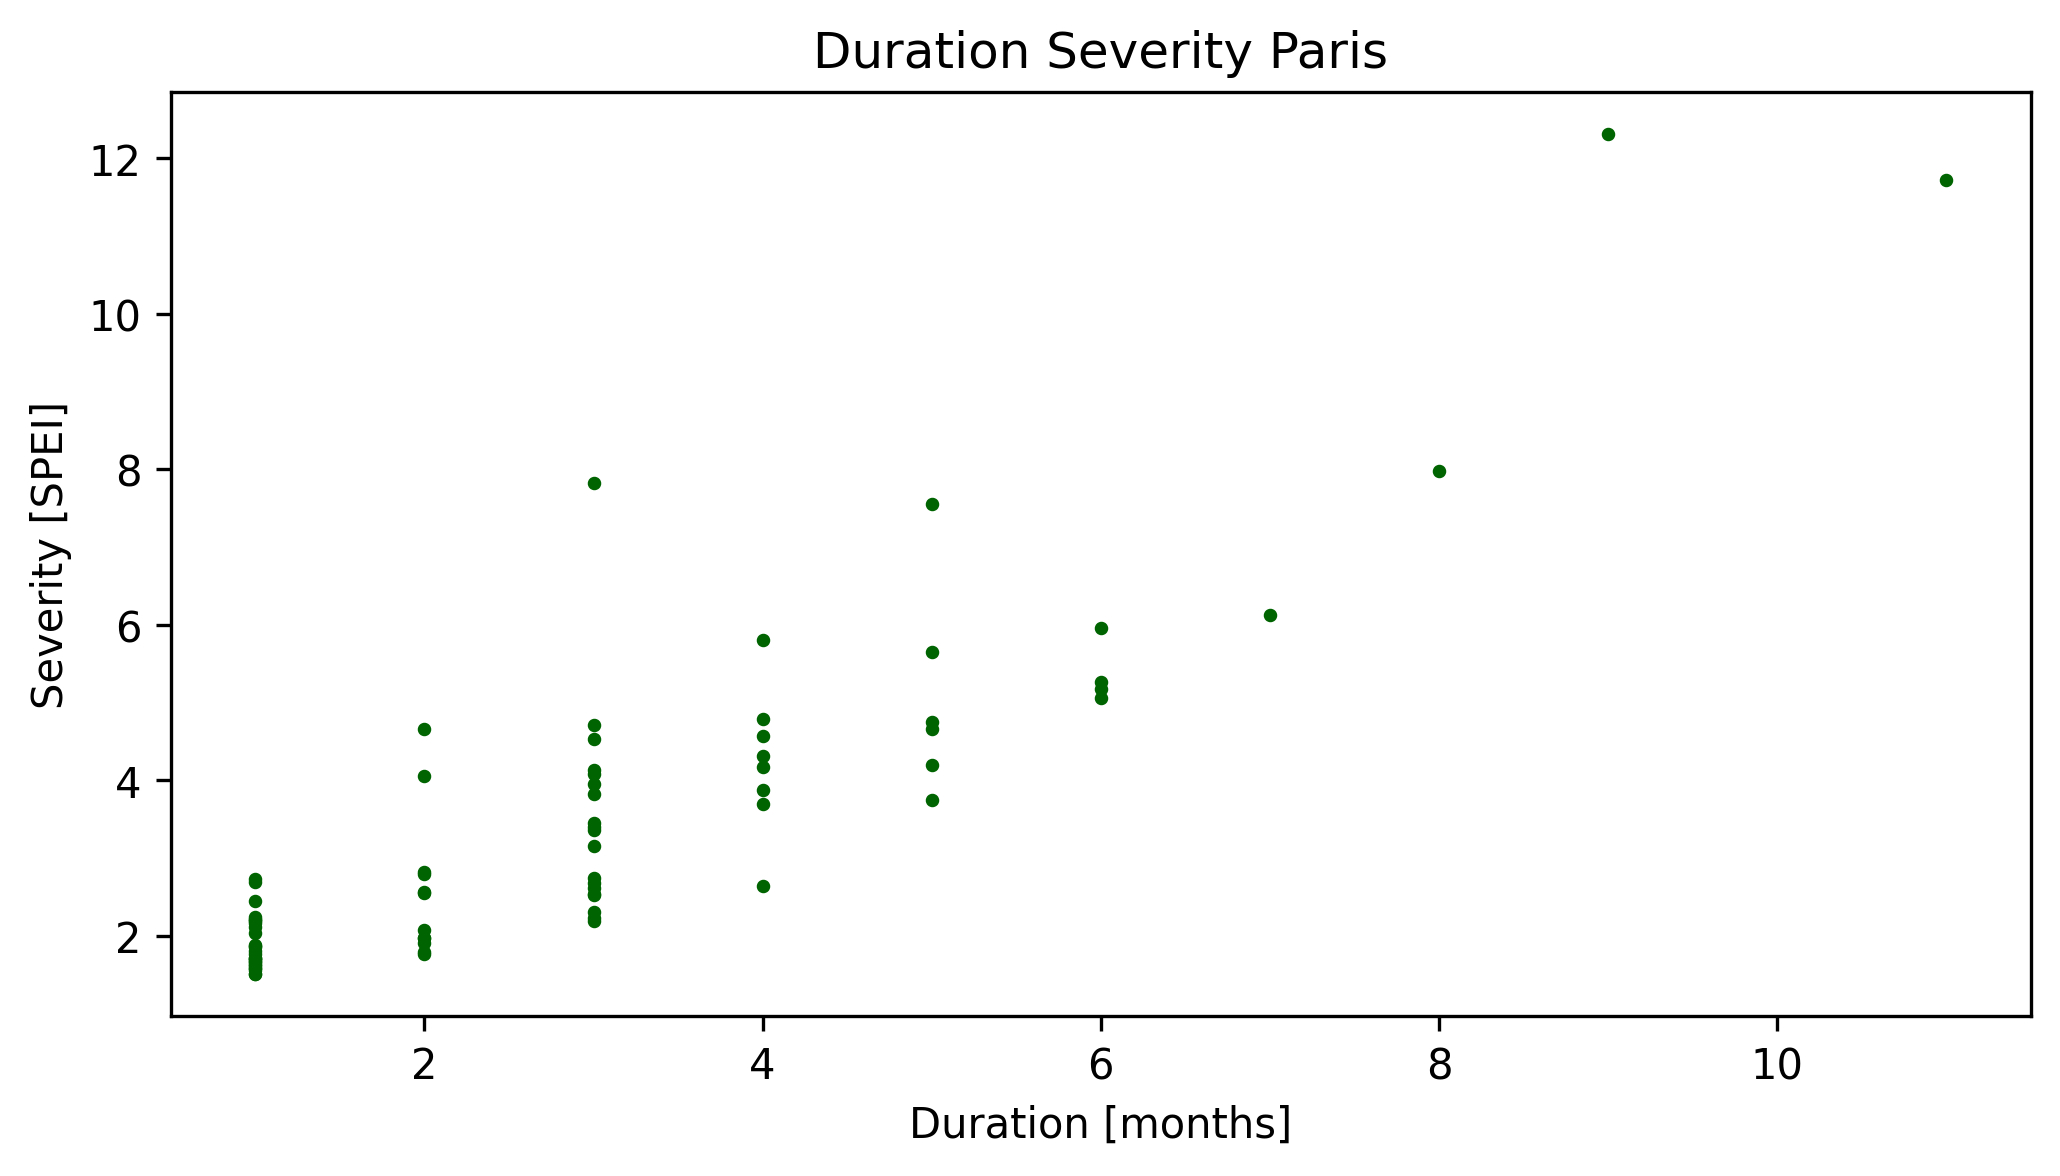

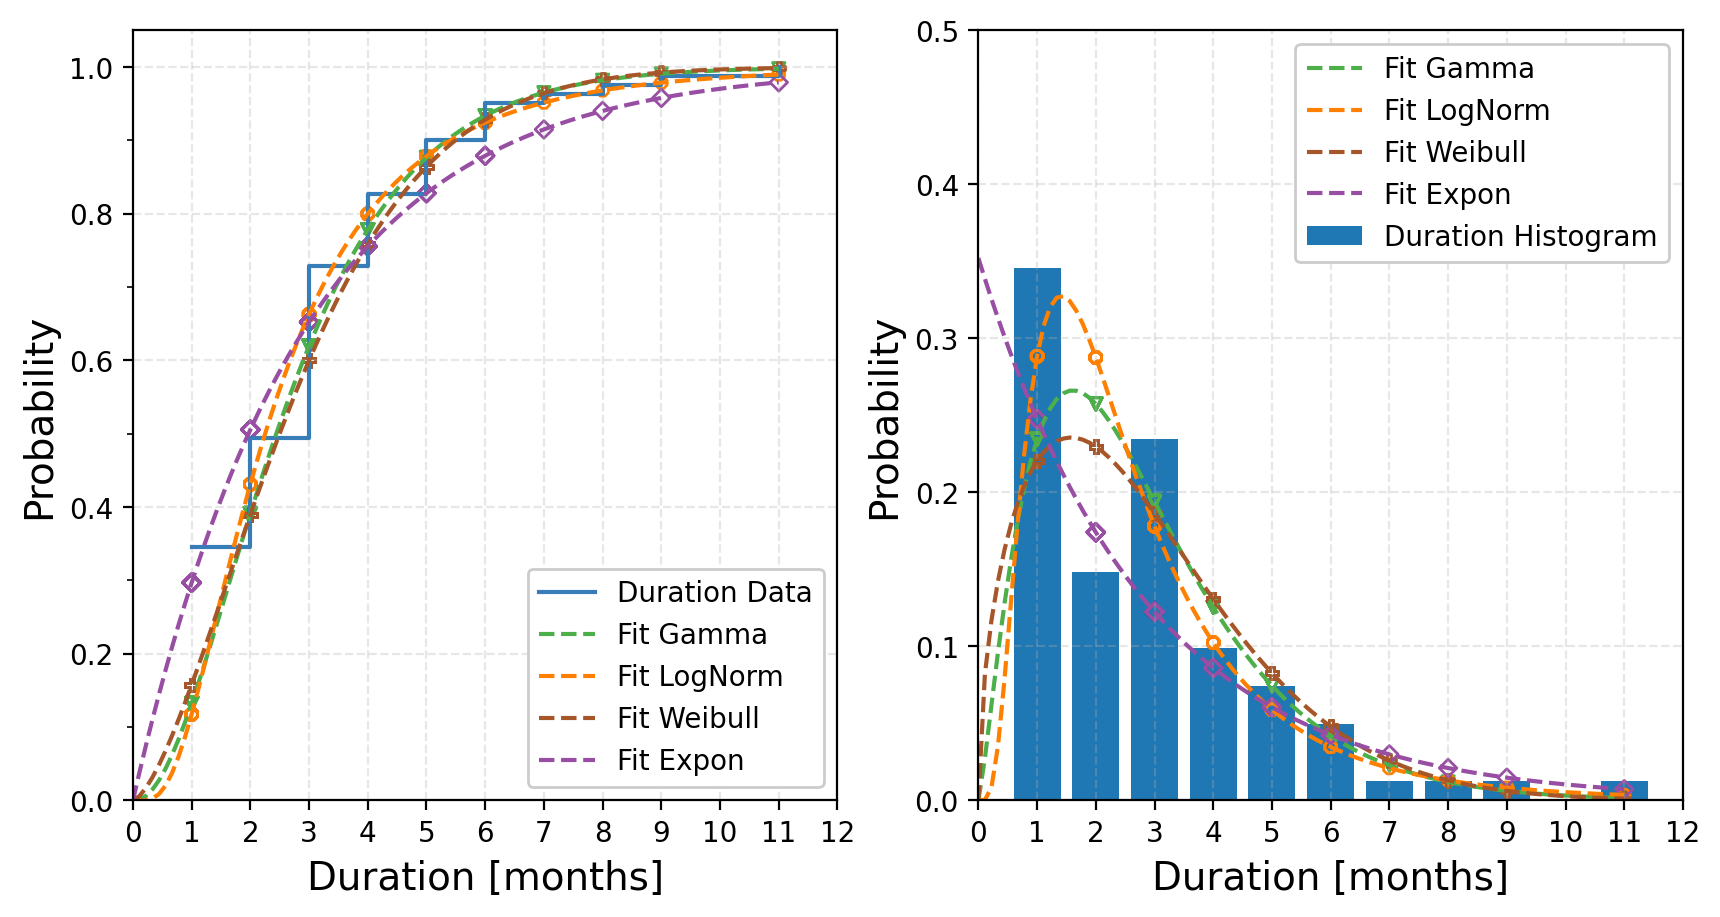

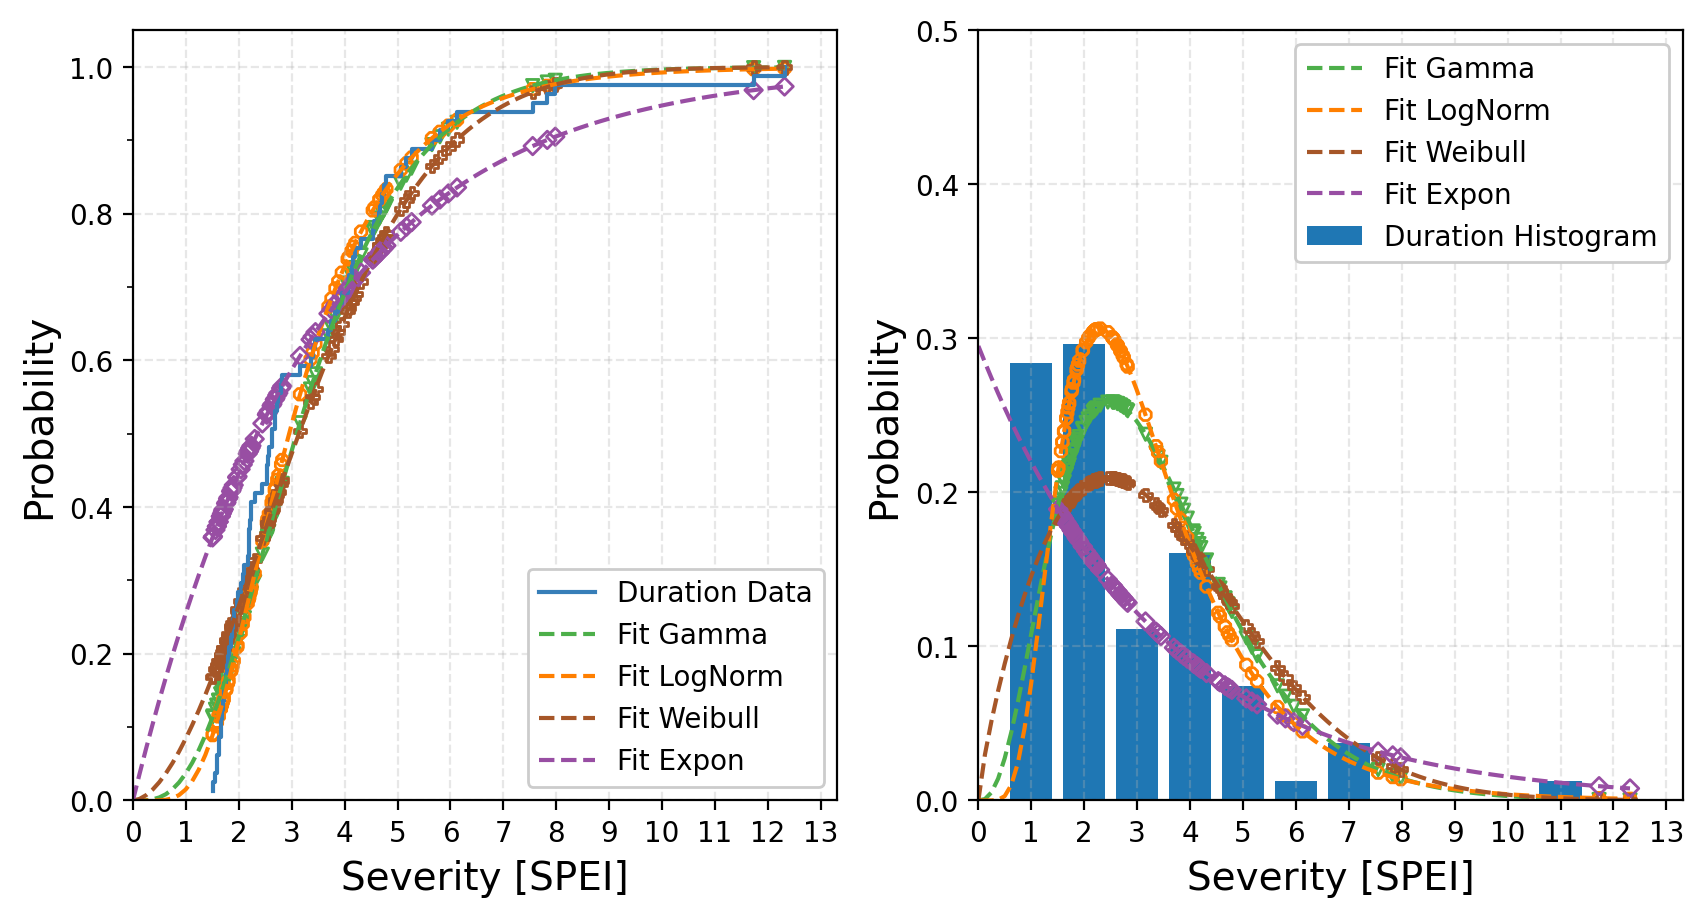

In [20]:
#Define the array for calcultion
index = spei_M1_arr_15
index_name = 'spei_M1_arr_15'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Plotting the Pairs
if plotter==True:
    fig1, ax1 = plt.subplots(ncols = 1, nrows = 1,figsize=(8,4),dpi=300)
    ax1.scatter(D_spei_histnat,S_spei_histnat,s=5,c="darkgreen")
    ax1.set_xlabel(r'Duration [months]',fontsize='10')
    ax1.set_ylabel(r'Severity [SPEI]',fontsize='10')
    plt.title("Duration Severity Paris")

#Giving important information about the data
print("number of pairs",len(D_spei_histnat))
print("PearsonR Duration and Severity:",stats.pearsonr(D_spei_histnat, S_spei_histnat))

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(min(D_S_array['Duration']), max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Plotting the Duration fits
if plotter==True:
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax2[0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Duration Data',where='post')
    ax2[0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[0].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[0].set_ylim(0,1.05)
    ax2[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax2[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax2[0].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[0].set_ylabel(r'Probability',fontsize='14')
    ax2[0].tick_params(axis='both', which='major', labelsize='10')
    ax2[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax2[1].bar(bins_count_D,count_D,label=r'Duration Histogram')
    ax2[1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax2[1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax2[1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',label=r'Fit Weibull',ls='--')
    ax2[1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=20,color='#a65628',marker="P",facecolors='none')
    ax2[1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',label=r'Fit Expon',ls='--')
    ax2[1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=20,color='#984ea3',marker="D",facecolors='none')
    ax2[1].set_xlim(0, D_S_array['Duration'].max()+1)
    ax2[1].set_ylim(0,0.5)
    ax2[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax2[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax2[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax2[1].set_xlabel(r'Duration [months]',fontsize='14')
    ax2[1].set_ylabel(r'Probability',fontsize='14')
    ax2[1].tick_params(axis='both', which='major', labelsize='10')
    ax2[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D,weights=weights_S)
bins_count_S = bins_count_S[:-1]

if plotter==True:
    fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi = 200)
    ax3[0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',label=r'Duration Data',where='post')
    ax3[0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[0].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[0].set_ylim(0,1.05)
    ax3[0].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend0 = ax3[0].legend(loc="lower right",fontsize='10')
    legend0.get_frame().set_alpha(0.5)
    legend0.get_frame().set_alpha(None)
    ax3[0].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[0].set_ylabel(r'Probability',fontsize='14')
    ax3[0].tick_params(axis='both', which='major', labelsize='10')
    ax3[0].grid(True,alpha=0.3,linestyle = 'dashed')
    ax3[1].bar(bins_count_S,count_S,label=r'Duration Histogram')
    ax3[1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',label=r'Fit Gamma',ls='--')
    ax3[1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=20,color='#4daf4a',marker="v",facecolors='none')
    ax3[1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',label=r'Fit LogNorm',ls='--')
    ax3[1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=20,color='#ff7f00',marker="8",facecolors='none')
    ax3[1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',label=r'Fit Weibull',ls='--')
    ax3[1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=20,color='#a65628',marker="P",facecolors='none')
    ax3[1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',label=r'Fit Expon',ls='--')
    ax3[1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=20,color='#984ea3',marker="D",facecolors='none')
    ax3[1].set_xlim(0, D_S_array['Severity'].max()+1)
    ax3[1].set_ylim(0,0.5)
    ax3[1].xaxis.set_major_locator(MultipleLocator(1))# defines setting of the small ticks
    ax3[1].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
    legend1 = ax3[1].legend(loc="upper right",fontsize='10')
    legend1.get_frame().set_alpha(0.5)
    legend1.get_frame().set_alpha(None)
    ax3[1].set_xlabel(r'Severity [SPEI]',fontsize='14')
    ax3[1].set_ylabel(r'Probability',fontsize='14')
    ax3[1].tick_params(axis='both', which='major', labelsize='10')
    ax3[1].grid(True,alpha=0.3,linestyle = 'dashed')

#Creating pd.array for Testing Duration Fits
print("Duration Fit:")
dis=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm = np.array([aic(len(param_expon_D)-1,expon.logpdf(D_S_array['Duration'], *param_expon_D)),
                    aic(len(param_gamma_D)-1,gamma.logpdf(D_S_array['Duration'], *param_gamma_D)),
                    aic(len(param_lognorm_D)-1,lognorm.logpdf(D_S_array['Duration'], *param_lognorm_D)),
                    aic(len(param_weibull_D)-1,weibull.logpdf(D_S_array['Duration'], *param_weibull_D))])
MSE_adap = np.array([mse_2(len(param_expon_D)-1,expon.cdf(D_S_array['Duration'],*param_expon_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_gamma_D)-1,gamma.cdf(D_S_array['Duration'],*param_gamma_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_lognorm_D)-1,lognorm.cdf(D_S_array['Duration'],*param_lognorm_D),cdf_D[D_S_array['Duration']-1]),
                       mse_2(len(param_weibull_D)-1,weibull.cdf(D_S_array['Duration'],*param_weibull_D),cdf_D[D_S_array['Duration']-1])])
KS_p = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).pvalue,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).pvalue])
KS_dist = np.array([stats.kstest(D_S_array['Duration'],stats.expon.cdf,args=param_expon_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.gamma.cdf,args=param_gamma_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.lognorm.cdf,args=param_lognorm_D).statistic,
                stats.kstest(D_S_array['Duration'],stats.weibull_min.cdf,args=param_weibull_D).statistic])
Distribution = pd.Series(dis, name='Distribution')
AIC_normal = pd.Series(AIC_norm, name='AIC_normal')
MSE_adapted = pd.Series(MSE_adap, name='MSE_adapted')
KS_pValue = pd.Series(KS_p, name='KS_pValue')
KS_Distance = pd.Series(KS_dist, name='KS_Distance')
Duration_fit = pd.concat([Distribution,AIC_normal,MSE_adapted,KS_pValue,KS_Distance], axis=1)
display(Duration_fit)
print("-----> best fit according to AIC_normal:", Distribution[np.argmin(AIC_normal)])

#Creating pd.array for Testing Severity Fits
print("Severity Fit:")
dis_S=np.array(['Expon','Gamma','LogNorm','Weibull'])
AIC_norm_S = np.array([aic(len(param_expon_S)-1,expon.logpdf(D_S_array['Severity'], *param_expon_S)),
                    aic(len(param_gamma_S)-1,gamma.logpdf(D_S_array['Severity'], *param_gamma_S)),
                    aic(len(param_lognorm_S)-1,lognorm.logpdf(D_S_array['Severity'], *param_lognorm_S)),
                    aic(len(param_weibull_S)-1,weibull.logpdf(D_S_array['Severity'], *param_weibull_S))])
MSE_adap_S = np.array([mse_2(len(param_expon_S)-1,expon.cdf(np.sort(D_S_array['Severity']),*param_expon_S),cdf_histogram_S[1:]),
                    mse_2(len(param_gamma_S)-1,gamma.cdf(np.sort(D_S_array['Severity']),*param_gamma_S),cdf_histogram_S[1:]),
                    mse_2(len(param_lognorm_S)-1,lognorm.cdf(np.sort(D_S_array['Severity']),*param_lognorm_S),cdf_histogram_S[1:]),
                    mse_2(len(param_weibull_S)-1,weibull.cdf(np.sort(D_S_array['Severity']),*param_weibull_S),cdf_histogram_S[1:])])
KS_p_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).pvalue,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).pvalue])
KS_dist_S = np.array([stats.kstest(D_S_array['Severity'],stats.expon.cdf,args=param_expon_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.gamma.cdf,args=param_gamma_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.lognorm.cdf,args=param_lognorm_S).statistic,
                stats.kstest(D_S_array['Severity'],stats.weibull_min.cdf,args=param_weibull_S).statistic])
Distribution_S = pd.Series(dis_S, name='Distribution')
AIC_normal_S = pd.Series(AIC_norm_S, name='AIC_normal')
MSE_adapted_S = pd.Series(MSE_adap_S, name='MSE_adapted')
KS_pValue_S = pd.Series(KS_p_S, name='KS_pValue')
KS_Distance_S = pd.Series(KS_dist_S, name='KS_Distance')
Severity_fit = pd.concat([Distribution_S,AIC_normal_S,MSE_adapted_S,KS_pValue_S,KS_Distance_S], axis=1)
display(Severity_fit)
print("-----> best fit according to AIC_normal:", Distribution_S[np.argmin(AIC_normal_S)])